# Modelagem Preditiva para Análise de Crédito

# Resumo

Este notebook teve como objetivo avaliar modelos interpretáveis para uso em um contexto de decisão de crédito, com foco em estabilidade, capacidade discriminativa e viabilidade econômica, evitando uma abordagem puramente orientada à maximização de métricas preditivas.

**Pergunta que este notebook responde:**
*Qual modelo interpretável é tecnicamente sólido e economicamente razoável para ser o baseline de crédito?*

Inicialmente, foram avaliadas diferentes variantes de regressão logística, incluindo a versão padrão, versões regularizadas (L1, L2 e Elastic Net) e um modelo baseado em WOE + Logit, amplamente utilizado em ambientes regulados. Todos os modelos foram avaliados sob um mesmo protocolo metodológico, utilizando validação cruzada estratificada, predições out-of-fold (OOF) e um conjunto holdout para confirmação de generalização.

Os resultados indicaram que a regressão logística regularizada com Elastic Net apresentou desempenho consistentemente superior em termos de separação de risco (AUC e KS), calibração (Brier Score e LogLoss) e ganho econômico sob uma matriz de custos fixa, mantendo comportamento estável fora da amostra. As análises de estabilidade — incluindo curvas de aprendizado e a sobreposição das curvas de AUC e KS entre OOF e holdout — não indicaram sinais de overfitting estrutural, reforçando a robustez do modelo para uso em decisões subsequentes.

O modelo WOE + Logit, por sua vez, apresentou maior estabilidade relativa, porém à custa de uma perda material de performance e retorno esperado. Essa perda foi diretamente associada à necessidade de exclusão de variáveis com elevado poder discriminativo devido à ausência de monotonicidade, um trade-off considerado não vantajoso do ponto de vista de negócio no contexto deste projeto. Diante disso, o modelo WOE foi avaliado como alternativa de alta governança, mas não foi levado adiante como candidato principal para definição de política de crédito.

# Obejtivos

Desenvolver, avaliar e interpretar modelos explicáveis de risco de crédito, servindo como baseline técnico, benchmark regulatório e fonte de insights para definição de políticas de decisão.

# Importando as bibliotecas

In [2]:
# Manipulação de Dados
import numpy as np
import pandas as pd
import json
import joblib

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns



# Modelagem, Validação e Pipelines
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    learning_curve,
    cross_val_predict,

)


# Baseline
from sklearn.dummy import DummyClassifier

# Pipelines
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from optbinning import OptimalBinning

# Pré-processamento
from sklearn.preprocessing import (
    StandardScaler,
    PowerTransformer
)


# Métricas e Avaliação
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
    brier_score_loss,
    log_loss,
    precision_recall_curve,
    average_precision_score
)


# Funções Auxiliares
import utils.aux_func as af
from utils.paths import (
    DATA_RAW, 
    DATA_PROCESSED,
    MODELS_ARTIFACTS_DIR,
    SPLITS_DIR,
    METRIC_ARTIFACTS_DIR
)

# Configurações Gerais
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.dpi"] = 400
pd.set_option("display.max_columns", None)


pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(suppress=True, precision=3)

# Importando os dados tratados

In [3]:
df = pd.read_parquet(DATA_PROCESSED / "Base_Inadimplencia_Tratada.parquet")
df.head(10)

,Idade,Valor_Emprestimo,Duracao_Emprestimo,Escolaridade,Tipo_Moradia,Saldo_Investimento_Moderado,Saldo_Investimento_Pouco,Saldo_Investimento_Sem investimento,Saldo_Conta_Corrente_Moderado,Saldo_Conta_Corrente_Pouco,Saldo_Conta_Corrente_Sem conta,Inadimplencia
0,67,1169,6,1,0,0,0,1,0,1,0,0
1,22,5951,48,1,0,0,1,0,1,0,0,1
2,49,2096,12,0,0,0,1,0,0,0,1,0
3,45,7882,42,1,2,0,1,0,0,1,0,0
4,53,4870,24,1,2,0,1,0,0,1,0,1
5,35,9055,36,0,2,0,0,1,0,0,1,0
6,53,2835,24,1,0,0,0,0,0,0,1,0
7,35,6948,36,2,1,0,1,0,1,0,0,0
8,61,3059,12,0,0,0,0,0,0,0,1,0
9,28,5234,30,2,0,0,1,0,1,0,0,1


In [4]:
df.shape

(1000, 12)

# Definindo o Setup dos Dados

## Splits

In [5]:
target = 'Inadimplencia'

# features
X = df.drop(target, axis=1)

# target
y = df[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 11), (300, 11), (700,), (300,))

## Estratégia de Validação

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Pipeline do Modelo de Regressão Logística

A estratégia de padronização adotada será a transformação pelo método Yeo-Johnson e StandardScaler. Isso porque durante a etapa de exploração dos dados ficou evidente o alongamento das caudas das variáveis númericas, portanto vamos procurar reduzir a assimetria para obter relações mais lineares e padronizar esses dados.

Além disso, para lidar com o moderado desbalanceamento dos dados, vamos utilizar o argumento `class_weight` para realizar uma ponderação das classes, evitando técnicas que alteram artificialmente a distribuição da variável alvo.

In [8]:
# Pipeline base
logit_pipe = Pipeline([
    ("yeojohnson", PowerTransformer(method='yeo-johnson')),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight='balanced',
        max_iter=2000,
        random_state=42
    ))
])

## Métrica de Avaliação Econômica

A área do financeiro forneceu estimativas financeiras consolidadas para cada tipo de resultado possível, permitindo construir uma matriz de custos (ou matriz de payoff) que representa o impacto monetário direto de cada decisão. Essas estimativas incorporam margem do produto, perdas esperadas por inadimplência, custo de cobrança e oportunidade de receita perdida. Com base nessas informações, a matriz de payoff adotada é a seguinte:

| Tipo de Decisão              | Descrição                                                                                                                                                                                                      | Valor (R$)    |
| ---------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------- |
| **Verdadeiro Positivo (TP)** | O modelo **aprova um cliente que realmente pagaria**, gerando lucro líquido médio equivalente à margem financeira da operação.                                                                                 | **+327,13**   |
| **Falso Positivo (FP)**      | O modelo **aprova um cliente que se tornará inadimplente**, resultando em prejuízo líquido composto pela perda do principal não recuperado (80% do valor médio) acrescida do custo administrativo de cobrança. | **–2.717,01**|
| **Falso Negativo (FN)**      | O modelo **nega um cliente que pagaria**, gerando um custo de oportunidade equivalente ao lucro líquido que teria sido obtido com a concessão do crédito.                                                      | **–327,13**   |
| **Verdadeiro Negativo (TN)** | O modelo **nega corretamente um cliente inadimplente**. Não há desembolso nem perda financeira adicional, sendo o impacto econômico tratado como neutro.                                                       | **0,00**      |


In [9]:
# PREMISSAS ECONÔMICAS DO MODELO

# Valor médio do empréstimo / limite concedido
VALOR_MEDIO_EMPRESTIMO = 3271.26  # R$

# Margem líquida média quando o cliente paga (juros + tarifas - custos)
MARGEM_LIQUIDA = 0.10  # 10%

# Recuperação média em casos de inadimplência
RECOVERY_RATE = 0.20  # 20%

# Custo médio administrativo / cobrança por default
CUSTO_COBRANCA = 100.00  # R$

# COMPONENTES DE GANHO / PERDA

# Lucro líquido esperado ao aprovar um cliente adimplente
LUCRO_CLIENTE_BOM = MARGEM_LIQUIDA * VALOR_MEDIO_EMPRESTIMO

# Prejuízo líquido ao aprovar um cliente inadimplente:
# - perda do principal não recuperado
# - custo administrativo de cobrança
PREJUIZO_CLIENTE_MAU = (
    (1 - RECOVERY_RATE) * VALOR_MEDIO_EMPRESTIMO
    + CUSTO_COBRANCA
)


# Matriz de Ganho de Crédito
CREDIT_GAIN_MATRIX = np.array([
    [  LUCRO_CLIENTE_BOM,   -LUCRO_CLIENTE_BOM],   # y_true = 0 → [Aprova, Nega]
    [ -PREJUIZO_CLIENTE_MAU,           0.00]       # y_true = 1 → [Aprova, Nega]
])

In [10]:
def credit_gain_score_mean(
    y_true,
    y_prob,
    threshold=0.5,
    payoff_matrix=CREDIT_GAIN_MATRIX
):
    """
    Ganho econômico médio por cliente.
    Avalia um cenário de decisão fixo.
    """

    y_true = np.asarray(y_true).astype(int)

    if y_prob.ndim == 2:
        y_prob = y_prob[:, 1]

    y_decision = (y_prob >= threshold).astype(int) # 1 = Nega, 0 = Aprova
    gains = payoff_matrix[y_true, y_decision]

    return gains.mean()

def make_credit_gain_scorer_mean(threshold=0.5, payoff_matrix=CREDIT_GAIN_MATRIX):

    def scorer_fn(y_true, y_prob):
        return credit_gain_score_mean(
            y_true=y_true,
            y_prob=y_prob,
            threshold=threshold,
            payoff_matrix=payoff_matrix
        )

    return make_scorer(
        scorer_fn,
        greater_is_better=True,
        response_method="predict_proba"
    )

mean_gain_scorer = make_credit_gain_scorer_mean()

## Dicionário de Scores

A seleção de modelos nesta etapa é baseada exclusivamente em métricas independentes de threshold. Métricas dependentes de decisão e métricas econômicas são reportadas apenas para fins diagnósticos.

In [11]:
# definindo o score KS
ks_scorer = make_scorer(
    af.ks_stat,
    response_method="predict_proba"
)

# definindo o score Brier
brier_scorer = make_scorer(
    brier_score_loss,
    greater_is_better=False,
    response_method="predict_proba"
)


precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer = make_scorer(recall_score, zero_division=0)
f1_scorer = make_scorer(f1_score, zero_division=0)

scoring_model_selection = {
    'AUC': 'roc_auc',
    'KS': ks_scorer,
    'LogLoss': make_scorer(
        log_loss,
        greater_is_better=False,
        response_method='predict_proba'
    )
}


scoring_calibration = {
    'Brier': brier_scorer
}


scoring_diagnostics = {
    'Precision': precision_scorer,
    'Recall': recall_scorer,
    'F1': f1_scorer
}


scoring_business = {
    'Gain_mean': mean_gain_scorer
}


# definindo o dicionario de scores final
scoring = {
    **scoring_model_selection,
    **scoring_calibration,
    **scoring_business
}

# Baseline Econômico: Aprovar todos os empréstimos (30% default)

In [12]:
dummy_approve_all = DummyClassifier(strategy="constant", constant=0)
dummy_approve_all.fit(X_train, y_train)

gain = mean_gain_scorer(dummy_approve_all, X_test, y_test)
print(f"Ganho Médio aprovando tudo: R$ {gain:,.2f}")

Ganho Médio aprovando tudo: R$ -586.11


O fato da métrica de ganho médio baseado na matriz de payoff ser negativo, indica que a nossa operação de concessão de crédito está operando em um regime de prejuízo por cliente aprovado. Permanecer nesse cenário pode resultar no endividamento e falência da fintech.

# Regressão Logística Simples

In [13]:
logit_results = cross_validate(
    logit_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True
)


df_logit_results = pd.DataFrame(logit_results)
df_logit_results.T

,0,1,2,3,4
fit_time,0.040,0.035,0.035,0.039,0.036
score_time,0.005,0.006,0.006,0.006,0.005
test_AUC,0.802,0.761,0.732,0.686,0.779
train_AUC,0.769,0.779,0.787,0.792,0.769
test_KS,0.534,0.486,0.483,0.330,0.493
train_KS,0.451,0.473,0.474,0.479,0.438
test_LogLoss,-0.551,-0.614,-0.587,-0.659,-0.555
train_LogLoss,-0.578,-0.568,-0.560,-0.555,-0.577
test_Brier,-0.185,-0.211,-0.199,-0.233,-0.189
train_Brier,-0.197,-0.193,-0.190,-0.187,-0.197


In [14]:
def summarize_cv(
    cv_results,
    metrics_direction=None,
    relative_gap=True
):
    """
    Resume resultados de cross_validate com cálculo de gap treino-validação.

    Parameters
    ----------
    cv_results : dict
        Output do sklearn.model_selection.cross_validate
    metrics_direction : dict
        Direção esperada das métricas.
        Ex: {'AUC': 'max', 'LogLoss': 'min'}
    relative_gap : bool
        Se True, calcula gap relativo (%)

    Returns
    -------
    pd.DataFrame
    """

    rows = {}

    for key in cv_results:
        if not key.startswith("test_"):
            continue

        metric = key.replace("test_", "")
        test_scores = cv_results[key]
        train_scores = cv_results.get(f"train_{metric}")

        rows[metric] = {
            "train_mean": np.mean(train_scores) if train_scores is not None else np.nan,
            "train_std": np.std(train_scores) if train_scores is not None else np.nan,
            "val_mean": np.mean(test_scores),
            "val_std": np.std(test_scores),
        }

        if train_scores is not None:
            gap = rows[metric]["train_mean"] - rows[metric]["val_mean"]
            rows[metric]["gap_abs"] = gap

            if relative_gap:
                denom = abs(rows[metric]["train_mean"])
                rows[metric]["gap_rel_%"] = (gap / denom * 100) if denom != 0 else np.nan
        else:
            rows[metric]["gap_abs"] = np.nan
            rows[metric]["gap_rel_%"] = np.nan

    df = pd.DataFrame(rows).T

    # Ajuste semântico para métricas que devem ser minimizadas
    if metrics_direction:
        for metric, direction in metrics_direction.items():
            if metric in df.index and direction == "min":
                df.loc[metric, ["train_mean", "val_mean"]] *= -1
                df.loc[metric, ["gap_abs", "gap_rel_%"]] *= -1

    return df


In [15]:
metrics_direction = {
    "AUC": "max",
    "KS": "max",
    "LogLoss": "min",
    "Brier": "min",
    "Gain_mean": "max"
}

summary_logit = summarize_cv(
    logit_results,
    metrics_direction=metrics_direction
)

summary_logit

,train_mean,train_std,val_mean,val_std,gap_abs,gap_rel_%
AUC,0.779,0.009,0.752,0.040,0.027,3.464
KS,0.463,0.016,0.465,0.070,-0.002,-0.514
LogLoss,0.568,0.009,0.593,0.040,-0.026,-4.530
Brier,0.193,0.004,0.203,0.017,-0.010,-5.391
Gain_mean,-115.166,13.818,-133.749,57.383,18.583,16.136


A regressão logística apresentou boa capacidade discriminativa, com KS elevado e praticamente estável entre treino e validação, indicando robustez do ranking. As métricas probabilísticas mostraram degradação moderada fora da amostra, dentro do esperado. A leitura econômica, avaliada sob cenário fixo, foi utilizada apenas como referência.

# Regressão Logística Regularizada

## Penalidade - L1

In [16]:
# Analisando o parâmetro C
Cs = [0.01, 0.1, 1, 10]

resultados = []

for c in Cs:
    logit_l1 = Pipeline([
        ("yeojohnson", PowerTransformer(method='yeo-johnson')),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            C=c,
            penalty='l1',
            solver='saga',
            class_weight='balanced',
            max_iter=2000,
            random_state=42
        ))
    ])
    logit_l1.fit(X_train, y_train)

    clf = logit_l1.named_steps["clf"]
    n_feat = np.sum(clf.coef_[0] != 0)
    resultados.append((c, n_feat))

pd.DataFrame(resultados, columns=['C', 'Features Mantidas'])

,C,Features Mantidas
0,0.010,1
1,0.100,9
2,1.000,10
3,10.000,11


A análise do parâmetro de regularização L1 evidenciou comportamentos distintos conforme a intensidade da penalização. Para valores muito baixos de C, como C=0.01, a regularização mostrou-se excessivamente agressiva, resultando em um modelo praticamente colapsado, com retenção de apenas uma variável e perda completa de capacidade discriminativa. À medida que a penalização é suavizada, em C=0.1, observa-se uma redução significativa da complexidade do modelo, mantendo aproximadamente 80% das variáveis originais e já apresentando comportamento preditivo consistente. Para valores mais elevados, entre C=1.0 e C=10.0, a variação na sparsity torna-se marginal, indicando que a regularização passa a exercer papel limitado, aproximando o modelo do regime observado na regressão logística com penalização L2. Dessa forma, o regime de maior interesse para a regularização L1 concentra-se entre C=0.1 e C=1.0, enquanto valores como C=0.01 são descartados por comprometerem de forma significativa a capacidade preditiva do modelo.

In [17]:
Cs = [0.1, 1, 10]

all_summaries = []

for c in Cs:
    logit_l1 = Pipeline([
        ("yeojohnson", PowerTransformer(method='yeo-johnson')),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            C=c,
            penalty='l1',
            solver='saga',
            class_weight='balanced',
            max_iter=2000,
            random_state=42
        ))
    ])

    l1_results = cross_validate(
        logit_l1,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )

    model_name = f"L1_C={c}"

    summary = summarize_cv(
        l1_results,
        metrics_direction=metrics_direction
    )

    summary["model"] = model_name
    all_summaries.append(summary)

# concatena
df_l1_results = (
    pd.concat(all_summaries)
      .set_index("model", append=True)
      .swaplevel(0, 1)
      .sort_index()
)

df_l1_results

train_mean  train_std  val_mean  val_std  gap_abs  \
model                                                                   
L1_C=0.1 AUC             0.771      0.010     0.752    0.042    0.020   
         Brier           0.198      0.004     0.204    0.012   -0.007   
         Gain_mean    -130.354     14.414  -142.809   29.402   12.455   
         KS              0.418      0.021     0.431    0.061   -0.013   
         LogLoss         0.578      0.009     0.594    0.026   -0.016   
L1_C=1   AUC             0.779      0.009     0.752    0.039    0.027   
         Brier           0.193      0.004     0.203    0.017   -0.010   
         Gain_mean    -116.766     12.821  -131.736   51.685   14.971   
         KS              0.460      0.016     0.462    0.069   -0.002   
         LogLoss         0.568      0.009     0.593    0.038   -0.025   
L1_C=10  AUC             0.779      0.009     0.752    0.040    0.027   
         Brier           0.193      0.004     0.203    0.017   -0.011   
         Gain_mean    -114.932     13.446  -127.998   62.509   13.066   
         KS              0.466      0.016     0.470    0.075   -0.004   
         LogLoss         0.567      0.009     0.594    0.040   -0.026   

                    gap_rel_%  
model                          
L1_C=0.1 AUC            2.546  
         Brier         -3.514  
         Gain_mean      9.555  
         KS            -3.011  
         LogLoss       -2.695  
L1_C=1   AUC            3.417  
         Brier         -5.219  
         Gain_mean     12.821  
         KS            -0.332  
         LogLoss       -4.356  
L1_C=10  AUC            3.505  
         Brier         -5.461  
         Gain_mean     11.368  
         KS            -0.913  
         LogLoss       -4.602

A análise da tabela acima nos permite destacar alguns pontos importantes:
- O modelo `l1_C=0.1` apresentou métricas muito próximas do baseline (L2) com uma redução real de complexidade do modelo (9 features), representando bem o trade-off entre complexidade e capacidade discriminativa. Porém, a perda de KS não compensa;
- O modelo `l1_C=1.0` eliminou apenas uma variável, reduzindo a complexidade e manteve o mesmo desempenho do baseline. Esse modelo é um forte candidato uma vez que o modelo `l1_C=10` não eliminou nenhuma variável em relação ao baseline (L2), deixando de cumprir seu papel regulatório;

Dessa forma, o regime `l1_C=1.0` apresentou o melhor equilíbrio entre estabilidade, performance e retenção de variáveis, sendo selecionado para as análises subsequentes.

## ElasticNet

In [18]:
all_summaries_en = []
l1_ratios = [0.3, 0.5, 0.7]

for r in l1_ratios:
    logit_en = Pipeline([
        ("yeojohnson", PowerTransformer(method="yeo-johnson")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="elasticnet",
            solver="saga",
            l1_ratio=r,
            C=1,
            class_weight='balanced',
            max_iter=2000,
            random_state=42
        ))
    ])

    en_results = cross_validate(
        logit_en,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )

    model_name = f"ElasticNet_l1_r={r}"

    summary = summarize_cv(
        en_results,
        metrics_direction=metrics_direction
    )

    summary["model"] = model_name
    all_summaries_en.append(summary)

# concatena
df_en_results = (
    pd.concat(all_summaries_en)
      .set_index("model", append=True)
      .swaplevel(0, 1)
      .sort_index()
)

df_en_results

train_mean  train_std  val_mean  val_std  \
model                                                                     
ElasticNet_l1_r=0.3 AUC             0.779      0.009     0.752    0.040   
                    Brier           0.193      0.004     0.203    0.017   
                    Gain_mean    -115.400     13.762  -135.618   56.262   
                    KS              0.463      0.015     0.465    0.070   
                    LogLoss         0.568      0.009     0.593    0.039   
ElasticNet_l1_r=0.5 AUC             0.779      0.009     0.752    0.040   
                    Brier           0.193      0.004     0.203    0.017   
                    Gain_mean    -114.896     12.341  -132.671   50.439   
                    KS              0.462      0.015     0.465    0.071   
                    LogLoss         0.568      0.009     0.593    0.039   
ElasticNet_l1_r=0.7 AUC             0.779      0.009     0.752    0.039   
                    Brier           0.193      0.004     0.203    0.017   
                    Gain_mean    -115.130     12.186  -131.736   49.030   
                    KS              0.462      0.016     0.463    0.069   
                    LogLoss         0.568      0.009     0.593    0.039   

                               gap_abs  gap_rel_%  
model                                              
ElasticNet_l1_r=0.3 AUC          0.027      3.448  
                    Brier       -0.010     -5.338  
                    Gain_mean   20.218     17.520  
                    KS          -0.002     -0.441  
                    LogLoss     -0.025     -4.476  
ElasticNet_l1_r=0.5 AUC          0.027      3.425  
                    Brier       -0.010     -5.304  
                    Gain_mean   17.775     15.470  
                    KS          -0.002     -0.515  
                    LogLoss     -0.025     -4.442  
ElasticNet_l1_r=0.7 AUC          0.027      3.428  
                    Brier       -0.010     -5.270  
                    Gain_mean   16.606     14.424  
                    KS          -0.001     -0.110  
                    LogLoss     -0.025     -4.407

A avaliação do ElasticNet foi conduzida mantendo o parâmetro C fixo e variando o l1_ratio, de modo a analisar o equilíbrio entre penalizações L1 e L2. Os resultados indicaram desempenho estatístico praticamente idêntico entre os valores testados, tanto em termos de capacidade discriminativa quanto de estabilidade fora da amostra. Diante da ausência de ganhos relevantes associados a regimes mais próximos de L1 ou L2, optou-se por l1_ratio = 0.5, por representar um compromisso equilibrado e metodologicamente neutro entre as duas penalizações.

## Conclusão

| Modelo                          | AUC (val) | KS (val) | LogLoss (val) | Brier (val) | Gap AUC (%) | Gap KS (%) | Gain_mean (val) |
| ------------------------------- | --------- | -------- | ------------- | ----------- | ----------- | ---------- | --------------- |
| **Logit L2 (baseline)**         | 0.752     | 0.465    | 0.593         | 0.203       | 3.46        | −0.51      | −133.7          |
| **Logit L1 (C = 1)**            | 0.752     | 0.462    | 0.593         | 0.203       | 3.42        | −0.33      | −131.7          |
| **ElasticNet (l1_ratio = 0.5)** | 0.752     | 0.465    | 0.593         | 0.203       | 3.43        | −0.52      | −132.7          |



A comparação entre a regressão logística com penalização L2, L1 (C=1) e ElasticNet (C=1, l1_ratio=0.5) revelou desempenho estatístico praticamente idêntico entre os modelos, tanto em termos de capacidade discriminativa quanto de calibração e generalização. Diante da ausência de ganhos marginais relevantes em métricas tradicionais, a escolha do modelo foi orientada por critérios de robustez e controle de complexidade. O ElasticNet foi selecionado por oferecer um equilíbrio estrutural entre suavização e sparsity, reduzindo o risco de coeficientes instáveis sem sacrificar desempenho preditivo.

In [68]:
# atualizando o pipeline logit
logit_pipe = Pipeline([
    ("yeojohnson", PowerTransformer(method='yeo-johnson')),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        C=1,
        penalty='elasticnet',
        l1_ratio=0.5,
        solver='saga',
        class_weight='balanced',
        max_iter=2000,
        random_state=42
    ))
])

# Estabilidade do Modelo de Regressão Logística Regularizada

## Learning Curve (Curva de Aprendizado)

In [20]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=logit_pipe,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)


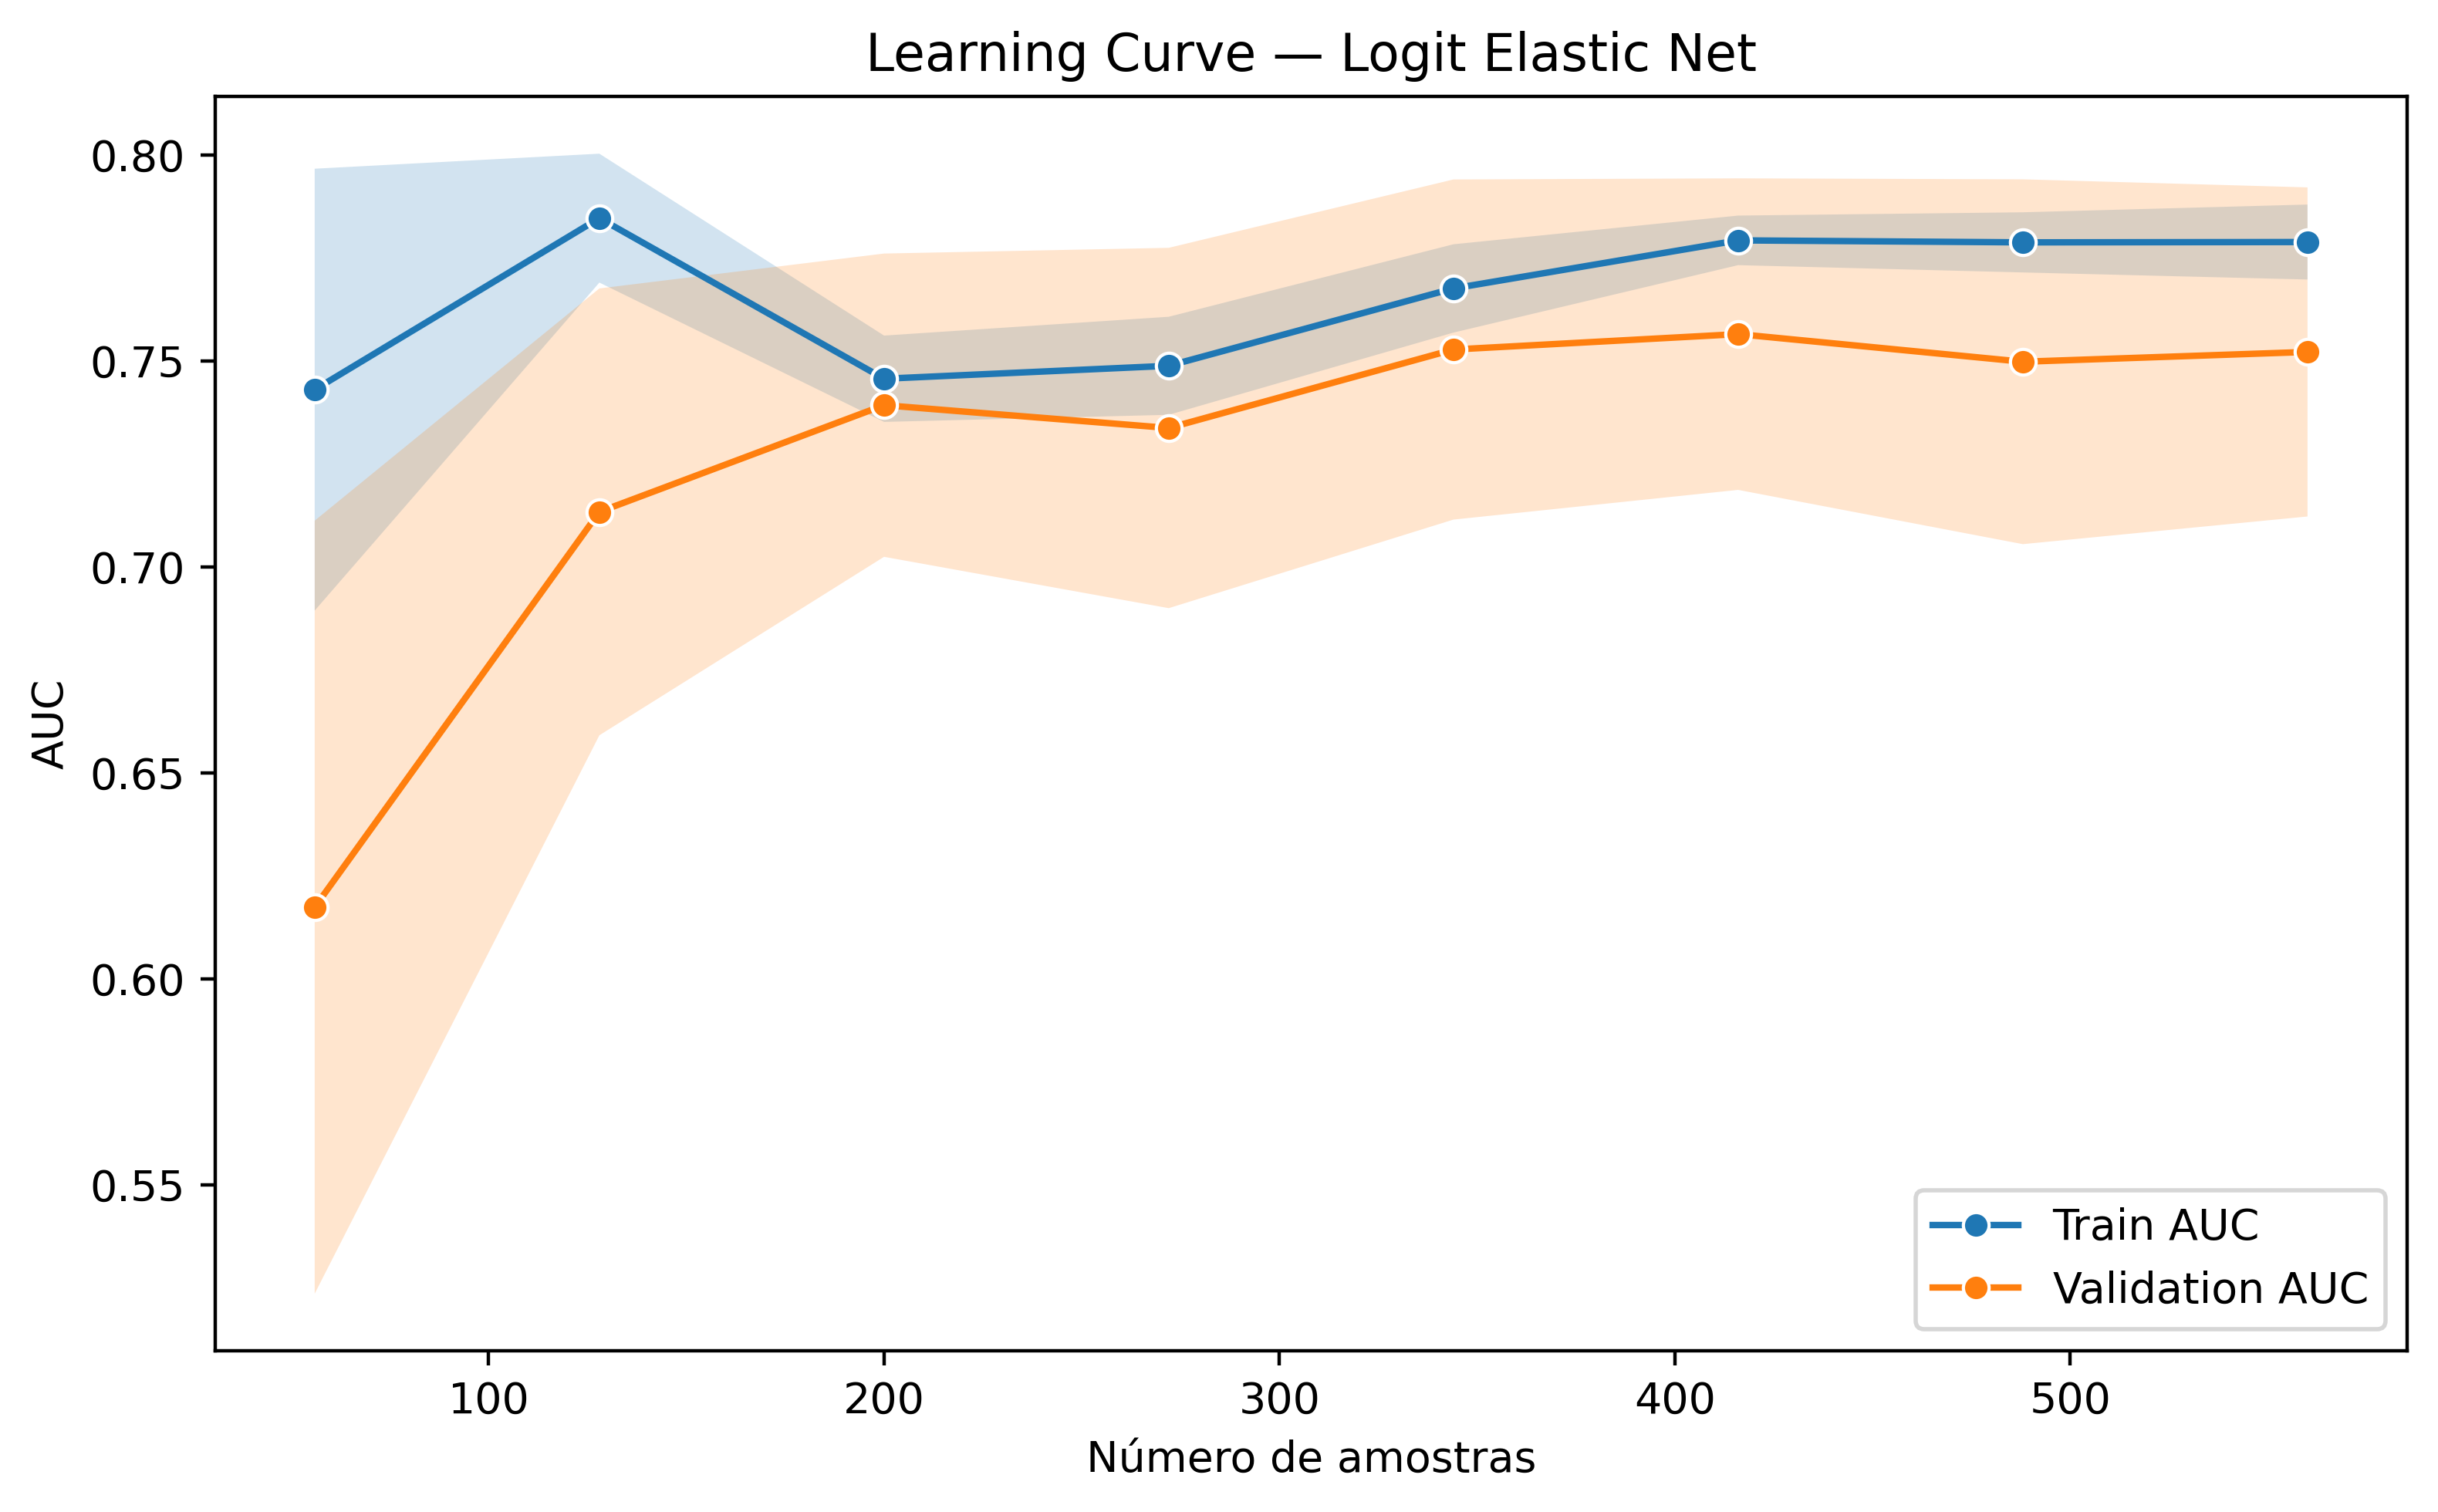

In [21]:
# Organizando os dados em DataFrame
df_lc = pd.DataFrame({
    "train_size": train_sizes,
    "Train AUC": train_mean,
    "Validation AUC": val_mean,
    "Train Std": train_std,
    "Validation Std": val_std
})

# Transformando para formato longo
df_long = df_lc.melt(
    id_vars="train_size",
    value_vars=["Train AUC", "Validation AUC"],
    var_name="Dataset",
    value_name="AUC"
)

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(
    data=df_long,
    x="train_size",
    y="AUC",
    hue="Dataset",
    marker="o"
)

# Bandas de incerteza (std)
plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.2
)

plt.fill_between(
    train_sizes,
    val_mean - val_std,
    val_mean + val_std,
    alpha=0.2
)

plt.xlabel("Número de amostras")
plt.ylabel("AUC")
plt.title("Learning Curve — Logit Elastic Net")
plt.legend(title="")
plt.tight_layout()
plt.show()


## ROC curve (OOF vs Holdout)

In [22]:
# OOF predictions (probabilidade da classe positiva)
y_oof_pred = cross_val_predict(
    estimator=logit_pipe,
    X=X_train,
    y=y_train,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# Predições no holdout (test)
logit_pipe.fit(X_train, y_train)
y_test_pred = logit_pipe.predict_proba(X_test)[:, 1]

# OOF
fpr_oof, tpr_oof, _ = roc_curve(y_train, y_oof_pred)
auc_oof = roc_auc_score(y_train, y_oof_pred)

# Holdout
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

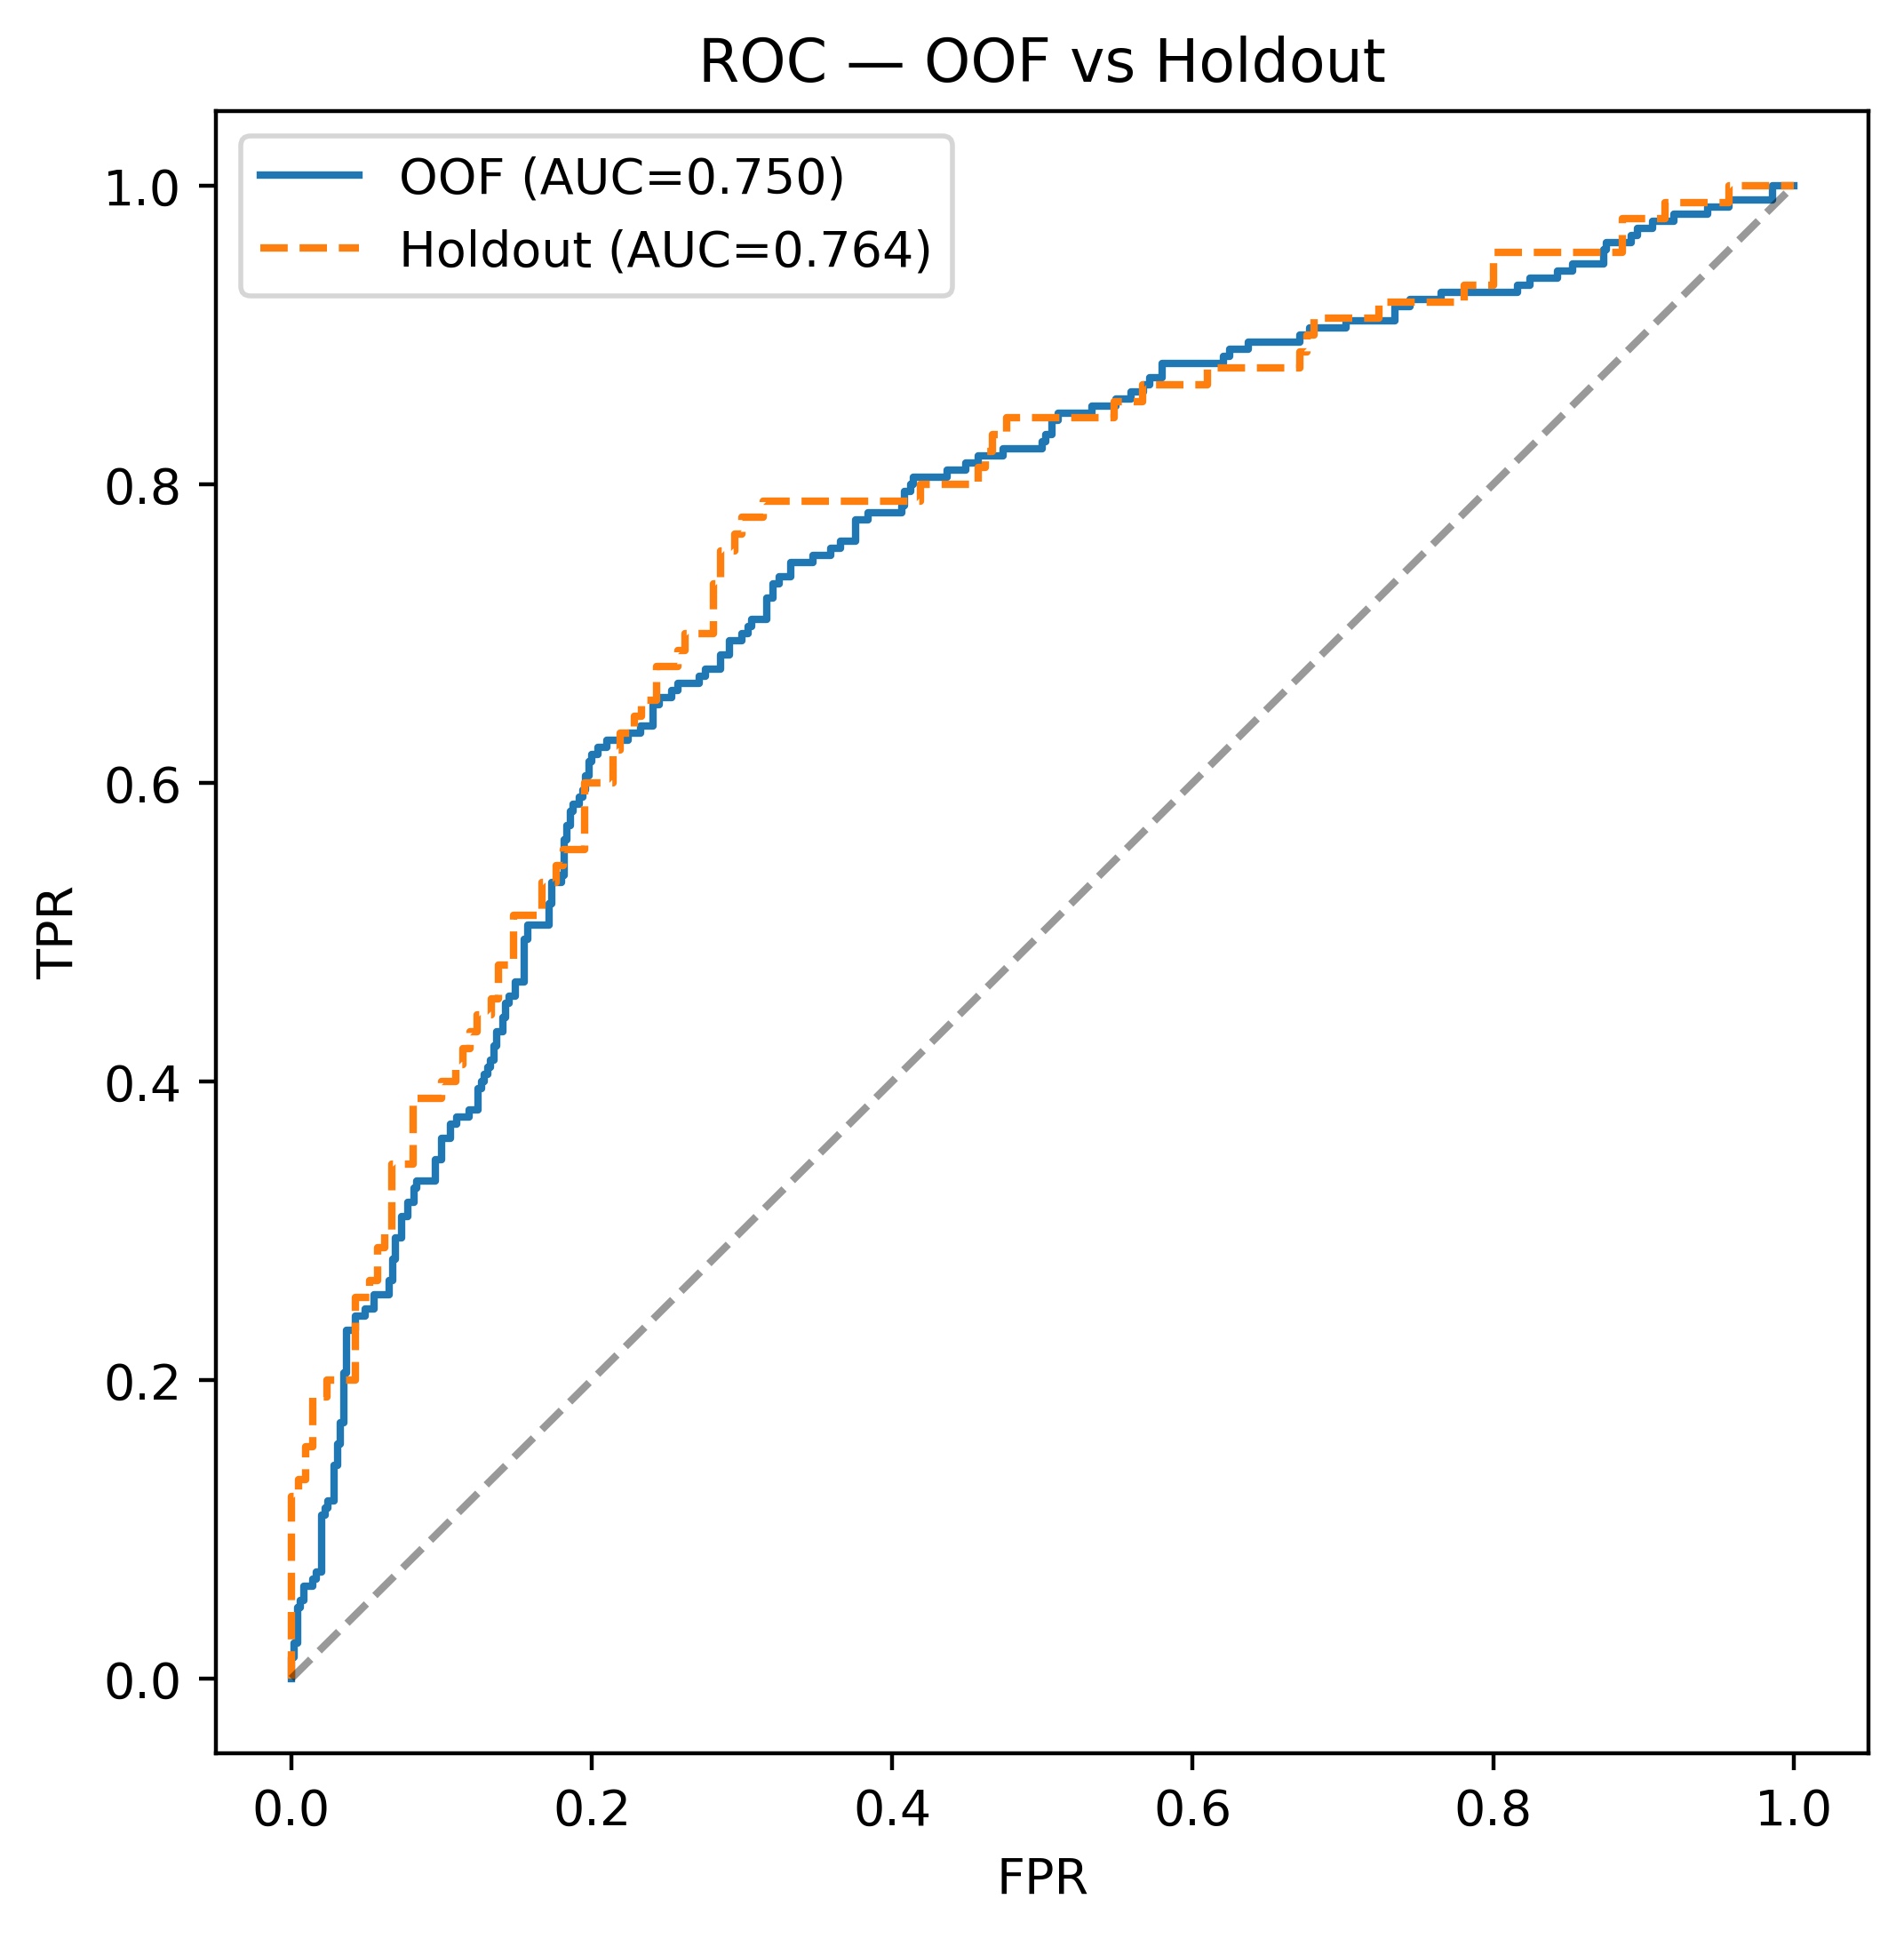

In [23]:
plt.figure(figsize=(6,6))
plt.plot(fpr_oof, tpr_oof, label=f"OOF (AUC={auc_oof:.3f})")
plt.plot(fpr_test, tpr_test, label=f"Holdout (AUC={auc_test:.3f})", linestyle="--")

plt.plot([0,1], [0,1], "k--", alpha=0.4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC — OOF vs Holdout")
plt.legend()
plt.show()


## KS Curve (OOF vs Holdout)

In [24]:
def ks_statistic(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return np.max(tpr - fpr)

ks_oof = ks_statistic(y_train, y_oof_pred)
ks_test = ks_statistic(y_test, y_test_pred)

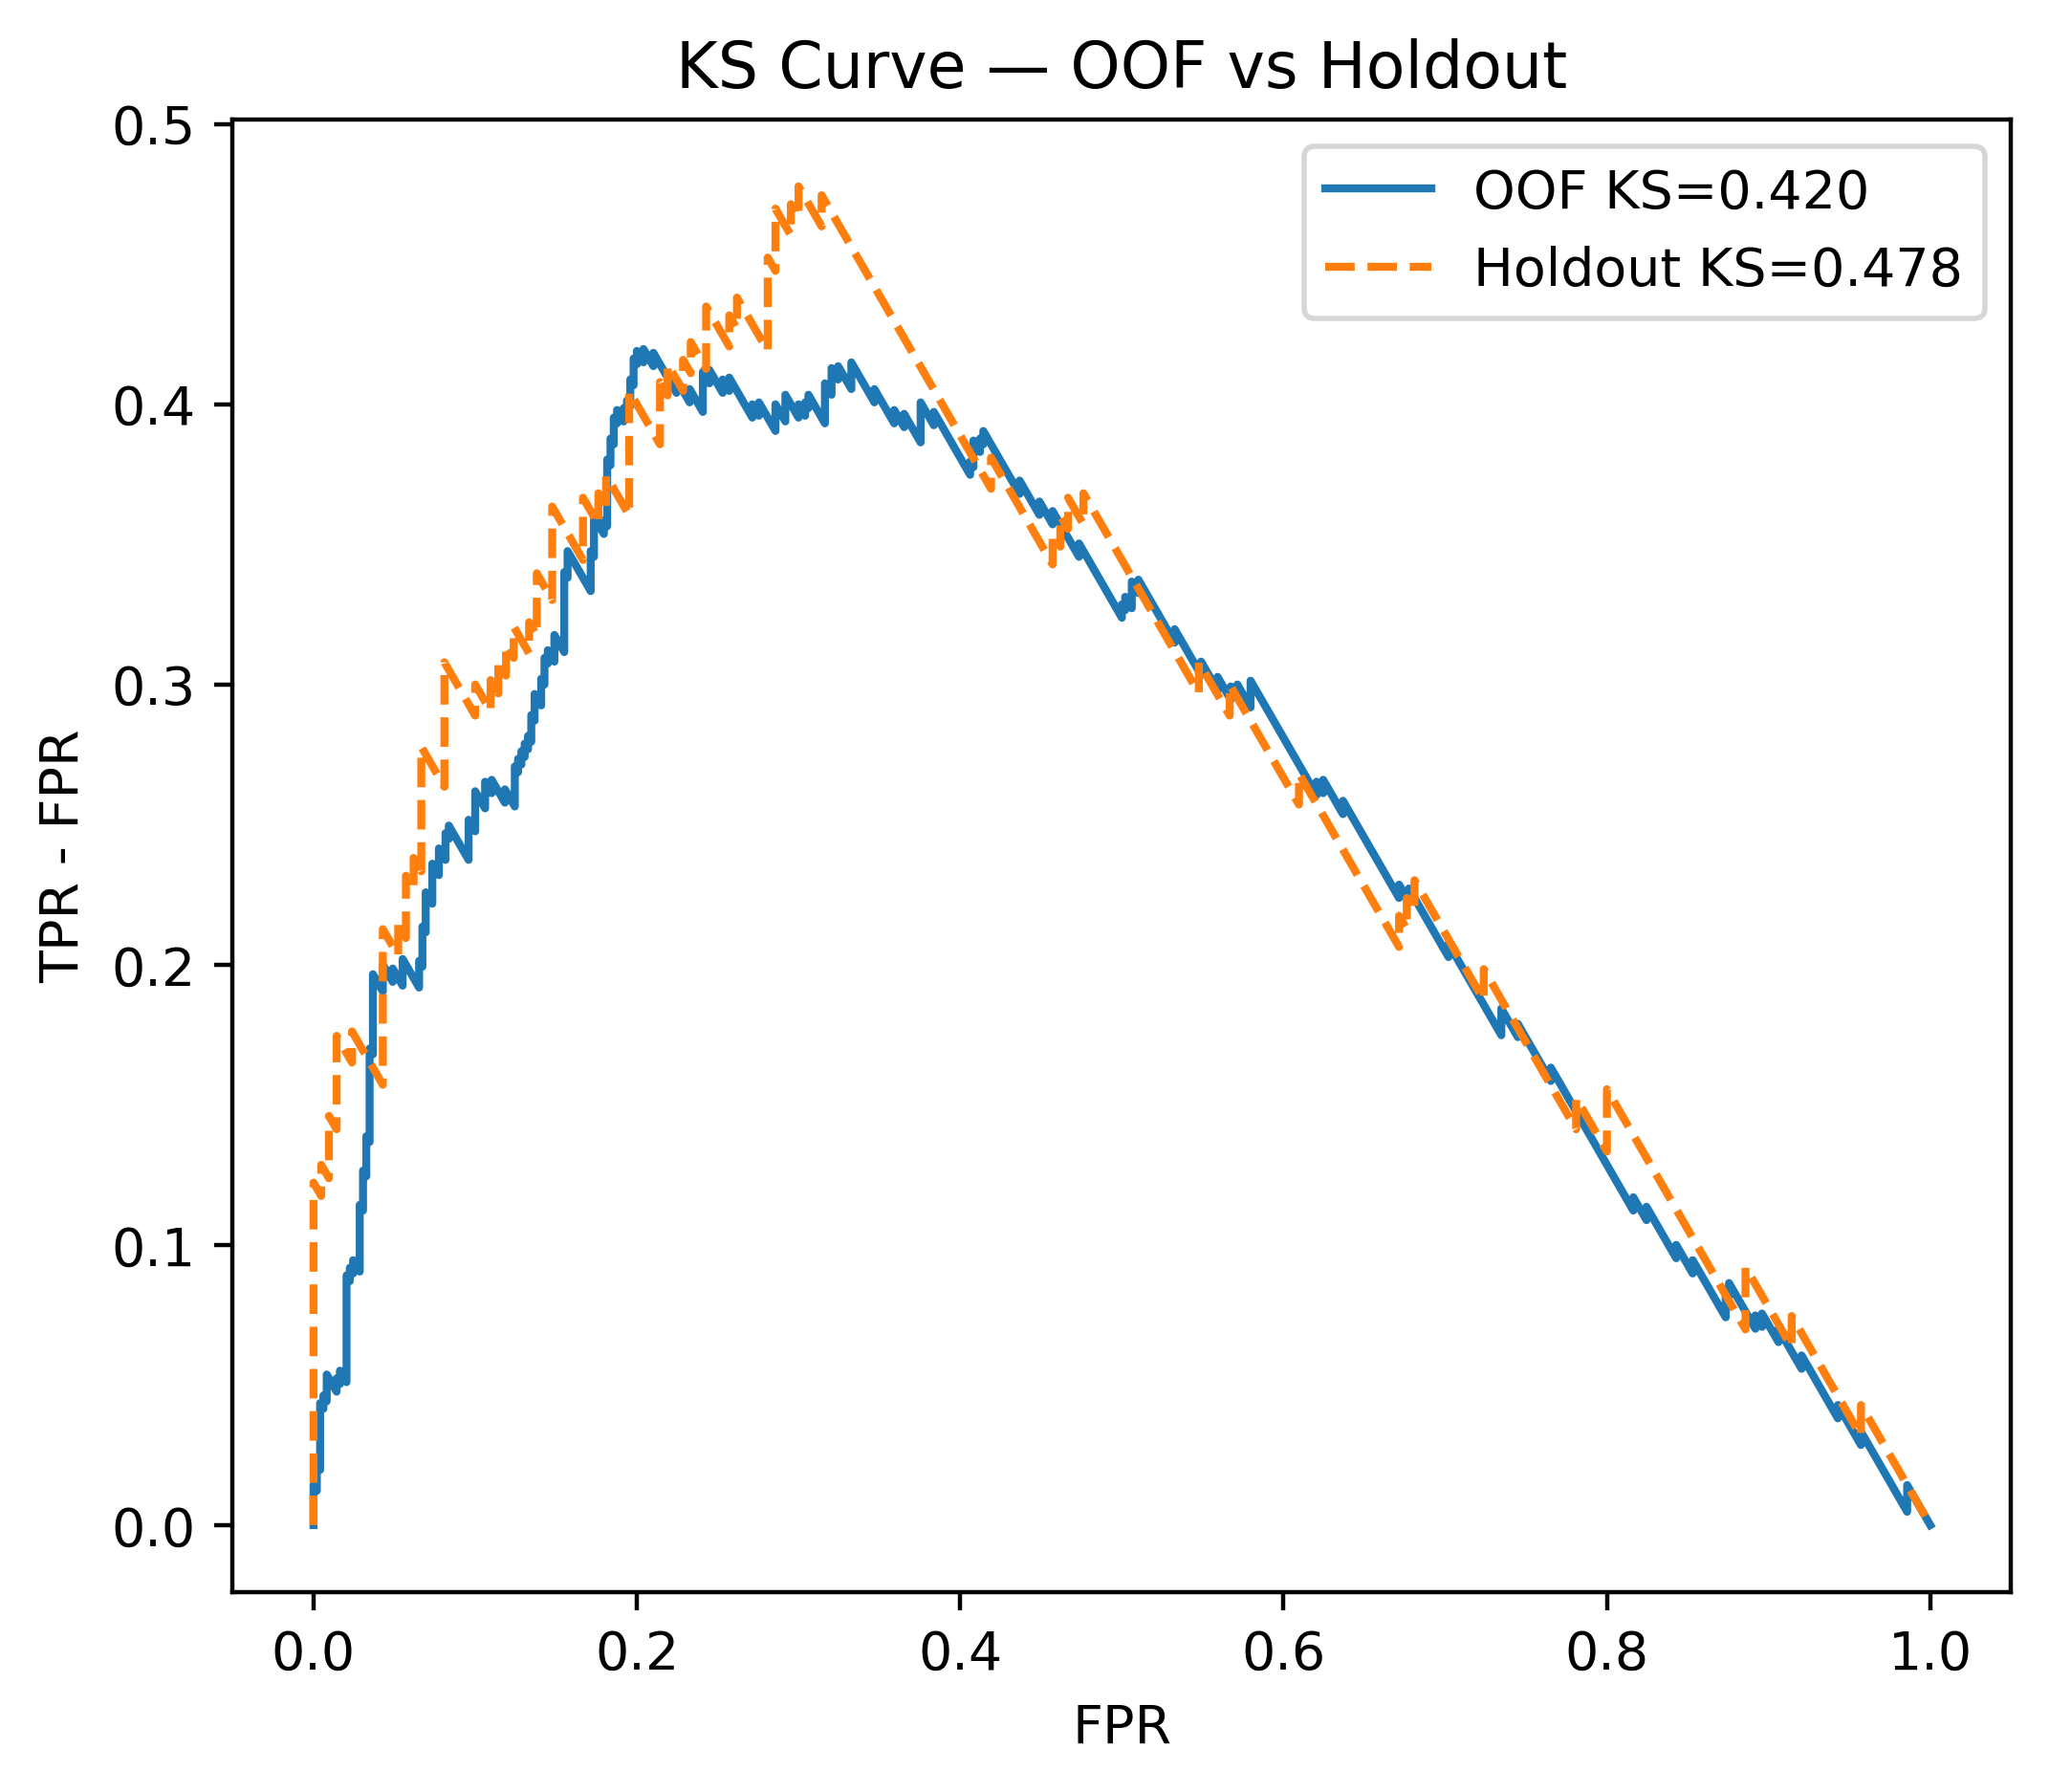

In [25]:
plt.figure(figsize=(6,5))
plt.plot(fpr_oof, tpr_oof - fpr_oof, label=f"OOF KS={ks_oof:.3f}")
plt.plot(fpr_test, tpr_test - fpr_test, label=f"Holdout KS={ks_test:.3f}", linestyle="--")

plt.xlabel("FPR")
plt.ylabel("TPR - FPR")
plt.title("KS Curve — OOF vs Holdout")
plt.legend()
plt.show()

## Conclusão

A sobreposição das curvas KS e ROC, obtidas a partir das predições OOF e do conjunto holdout, indica comportamento consistente do modelo fora da amostra, sem evidências de degradação significativa de performance. A curva de aprendizado indica convergência consistente entre desempenho de treino e validação, com ganho progressivo de performance à medida que o volume de dados aumenta. Não há indícios de overfitting estrutural.

# Interpretação do Modelo

# Modelo baseado em WOE (*Weight of Evidence*)

## Preparando a Base

In [26]:
# importando a base
df_woe = pd.read_excel(DATA_RAW / "Base_Inadimplencia.xlsx", sheet_name="Base")

# removendo a variavel Sexo
df_woe.drop(columns=['Sexo'], inplace=True)

## Forçando relação monotônica (merge de categorias)

Durante a análise exploratória, observou-se que as variáveis relacionadas a saldo apresentavam relação não monotônica com o risco de inadimplência. Para viabilizar sua inclusão no modelo WOE, as categorias foram reagrupadas com base em critérios econômicos, de modo a restabelecer a monotonicidade da taxa de evento. Essa abordagem permite preservar o sinal informativo das variáveis, garantindo coerência com a estrutura linear da regressão logística.

In [27]:
def merge_saldo_investimento(x):
    if pd.isna(x):
        return "Missing"
    if x in ["Pouco", "Moderado"]:
        return "Pouco_Moderado"
    elif x == "Alto":
        return "Alto"
    else:
        return "Sem_Investimento"


def merge_saldo_conta_corrente(x):
    if pd.isna(x):
        return "Missing"
    if x in ["Pouco", "Moderado"]:
        return "Pouco_Moderado"
    elif x == "Alto":
        return "Alto"
    else:
        return "Sem_Conta"


In [28]:
def preparar_df_para_woe(df, target):
    df_ = df.copy()

    df_["Saldo_Investimento"] = df_["Saldo_Investimento"].apply(
        merge_saldo_investimento
    )

    df_["Saldo_Conta_Corrente"] = df_["Saldo_Conta_Corrente"].apply(
        merge_saldo_conta_corrente
    )

    return df_


In [29]:
target = 'Inadimplencia'
df_woe_base = preparar_df_para_woe(df_woe, target)

# checando o resultado
for col in df_woe_base.select_dtypes(include=['object', 'category', 'str']).columns:
    print(f"\nColuna: {col}")
    print(df_woe_base[col].unique())


Coluna: Escolaridade
<ArrowStringArray>
['Graduacao', 'Pos Graduacao', 'Ensino Medio']
Length: 3, dtype: str

Coluna: Tipo_Moradia
<ArrowStringArray>
['Propria', 'De favor', 'Alugada']
Length: 3, dtype: str

Coluna: Saldo_Investimento
<ArrowStringArray>
['Sem_Investimento', 'Pouco_Moderado', 'Alto']
Length: 3, dtype: str

Coluna: Saldo_Conta_Corrente
<ArrowStringArray>
['Pouco_Moderado', 'Sem_Conta', 'Alto']
Length: 3, dtype: str


In [30]:
# Verificando a monotocidade
cat_vars = [col for col in df_woe_base.columns if (df_woe_base[col].dtype == 'object' or str(df_woe_base[col].dtype) == 'category' or df_woe_base[col].dtype == 'str') and col != target]

for var in cat_vars:
    tabela = (
        df_woe_base.groupby(var)
          .agg(
              Frequencia=(var, 'count'),
              Taxa_Alvo=(target, 'mean')
          )
          .assign(Taxa_Alvo=lambda x: (x['Taxa_Alvo'] * 100).round(2))
          .sort_values('Taxa_Alvo')
    )

    print(f"\n===== {var} =====")
    print(tabela)


===== Escolaridade =====
               Frequencia  Taxa_Alvo
Escolaridade                        
Pos Graduacao         200     28.000
Graduacao             630     29.520
Ensino Medio          170     34.120

===== Tipo_Moradia =====
              Frequencia  Taxa_Alvo
Tipo_Moradia                       
Propria              713     26.090
Alugada              179     39.110
De favor             108     40.740

===== Saldo_Investimento =====
                    Frequencia  Taxa_Alvo
Saldo_Investimento                       
Alto                       111     15.320
Sem_Investimento           183     17.490
Pouco_Moderado             706     35.550

===== Saldo_Conta_Corrente =====
                      Frequencia  Taxa_Alvo
Saldo_Conta_Corrente                       
Sem_Conta                    394     11.680
Alto                         108     19.440
Pouco_Moderado               498     46.790


Aqui temos um problema!

No contexto da modelagem baseada em WOE + Regressão Logística, é reconhecido que a abordagem clássica de scorecard pressupõe relações aproximadamente monotônicas entre as variáveis explicativas e o risco de inadimplência. Essa premissa decorre do fato de que a transformação WOE busca linearizar a relação entre os preditores e o log-odds de default, permitindo uma interpretação direta e estável dos coeficientes do modelo logístico.

Durante o desenvolvimento deste modelo, foram realizadas tentativas explícitas de impor monotonicidade às variáveis por meio de estratégias tradicionais de binning supervisionado e merge de categorias, conforme preconizado na literatura de scorecards clássicos. No entanto, mesmo após esses ajustes, as variáveis `Saldo_Investimentos` e `Saldo_Conta_Corrente`, mantiveram comportamento não monotônico, não apresentando o padrão esperado para uma representação estritamente aderente ao scorecard WOE tradicional.

Diante desse cenário, optou-se por manter essas variáveis no modelo, uma vez que se tratam de atributos considerados indispensáveis do ponto de vista de negócio, com elevado poder informativo e relevância prática para a decisão de crédito. A exclusão dessas variáveis implicaria uma perda material de capacidade discriminativa e de valor econômico, um trade-off que, neste contexto, não se mostrou negociável sob a ótica da área de negócio.

É importante destacar que essa decisão não decorre de desconhecimento conceitual, mas sim de uma escolha consciente. Reconhece-se que a manutenção de variáveis com relações não monotônicas descaracteriza o scorecard WOE clássico, comprometendo aspectos como governança, estabilidade temporal e interpretabilidade estrita. Por esse motivo, o modelo WOE + Logit aqui apresentado não deve ser interpretado como um modelo institucional ou regulatório, nem como base para definição de política de crédito.

Nesse projeto, o modelo WOE + logit é mantido com o objetivo de:
* investigar o impacto de transformações WOE em variáveis altamente informativas;
* enriquecer a análise de interpretabilidade;
* servir como referencial comparativo em relação ao modelo efetivamente selecionado para uso prático.



## Construção dos Binning WOE

In [31]:
woe_num_vars = [col for col in df_woe_base.select_dtypes(include=['int64', 'float64']).columns if col != target]
woe_cat_vars = [col for col in df_woe_base.select_dtypes(include=['object', 'category', 'str']).columns if col != target]

In [32]:
X_woe = df_woe_base.drop(columns=[target])
y_woe = df_woe_base[target]

In [33]:
X_train_woe, X_test_woe, y_train, y_test = train_test_split(
    X_woe,
    y_woe,
    test_size=0.3,
    stratify=y_woe,
    random_state=42
)

X_train_woe.shape, X_test_woe.shape, y_train.shape, y_test.shape

((700, 7), (300, 7), (700,), (300,))

In [34]:
def fit_woe_binning(X_train, y_train, num_vars, cat_vars):
    binning_models = {}

    # Numéricas
    for col in num_vars:
        optb = OptimalBinning(
            name=col,
            dtype="numerical",
            solver="cp",
            monotonic_trend="auto",
            min_n_bins=3,
            max_n_bins=6
        )
        optb.fit(X_train[col], y_train)
        binning_models[col] = optb

    # Categóricas
    for col in cat_vars:
        optb = OptimalBinning(
            name=col,
            dtype="categorical",
            solver="cp"
        )
        optb.fit(X_train[col], y_train)
        binning_models[col] = optb

    return binning_models


In [35]:
binning_models = fit_woe_binning(
    X_train_woe, y_train,
    woe_num_vars,
    woe_cat_vars
)

In [36]:
def transform_to_woe(X, binning_models):
    X_woe = pd.DataFrame(index=X.index)

    for col, optb in binning_models.items():
        X_woe[col] = optb.transform(X[col], metric="woe")

    return X_woe

In [37]:
X_train_woe = transform_to_woe(X_train_woe, binning_models)
X_test_woe  = transform_to_woe(X_test_woe, binning_models)

## Treinando o Modelo logit + WOE

In [38]:
logit_woe = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

logit_woe.fit(X_train_woe, y_train)

woe_results = cross_validate(
    logit_woe,
    X_train_woe,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True
)


summary_woe = summarize_cv(
    woe_results,
    metrics_direction=metrics_direction
)

summary_woe

,train_mean,train_std,val_mean,val_std,gap_abs,gap_rel_%
AUC,0.798,0.010,0.778,0.042,0.020,2.451
KS,0.488,0.024,0.483,0.066,0.005,1.011
LogLoss,0.548,0.011,0.567,0.031,-0.019,-3.512
Brier,0.185,0.005,0.193,0.013,-0.008,-4.102
Gain_mean,-101.435,19.860,-111.823,65.593,10.388,10.241


## WOE logit vs ElasticNet logit

| Modelo                              | AUC (val) | KS (val)   | LogLoss (val) | Brier (val) | Gap AUC (%) | Gap KS (%) | Gain_mean (val) |
| ----------------------------------- | --------- | ---------- | ------------- | ----------- | ----------- | ---------- | --------------- |
| **WOE + Logit**                     | 0.779   |  0.482   | 0.505       | 0.167     | 2.4       |  0.597     | ≈ -279.5        |
| **Logit ElasticNet (l1_ratio=0.5)** | 0.752   |  0.469   | 0.528       | 0.174     | 3.5       |  0.2      | ≈ -325.9        |


A validação desse modelo é realizada apenas de forma comparativa, tendo como principal referência a Regressão Logística Regularizada (Elastic Net), que foi selecionada como modelo base para as etapas subsequentes do projeto, incluindo a definição de faixas de risco e a construção de políticas de decisão orientadas a retorno econômico.

In [39]:
# oof predictions com woe
y_oof_pred_woe = cross_val_predict(
    logit_woe,
    X_train_woe,
    y_train,
    cv=cv,
    method="predict_proba"
)[:, 1]


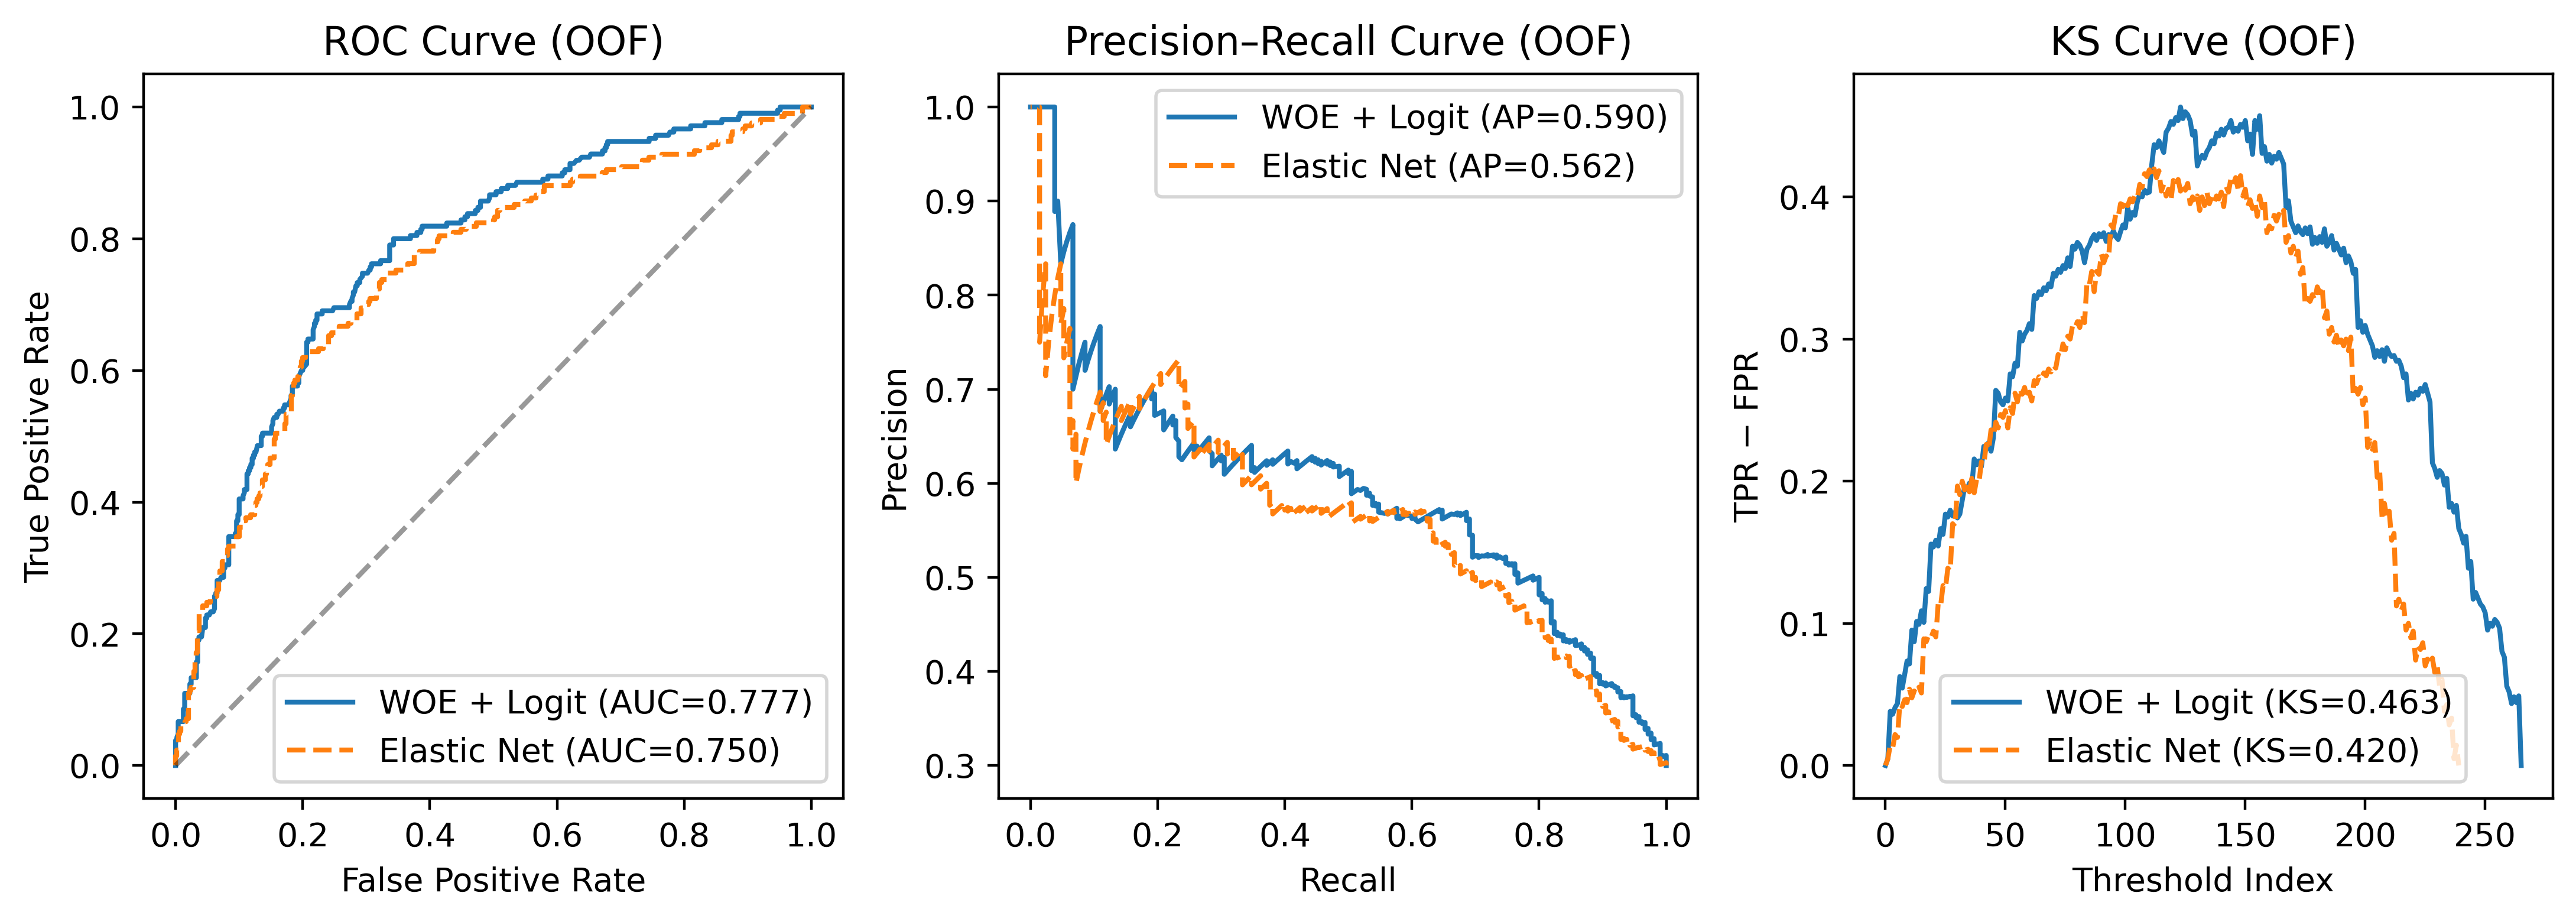

In [40]:
# Função KS
def ks_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    ks_values = tpr - fpr
    return ks_values, ks_values.max()

# ROC
fpr_woe, tpr_woe, _ = roc_curve(y_train, y_oof_pred_woe)
fpr_el, tpr_el, _ = roc_curve(y_train, y_oof_pred)

auc_woe = roc_auc_score(y_train, y_oof_pred_woe)
auc_el = roc_auc_score(y_train, y_oof_pred)

# Precision–Recall
prec_woe, rec_woe, _ = precision_recall_curve(y_train, y_oof_pred_woe)
prec_el, rec_el, _ = precision_recall_curve(y_train, y_oof_pred)

ap_woe = average_precision_score(y_train, y_oof_pred_woe)
ap_el = average_precision_score(y_train, y_oof_pred)

# KS
ks_woe, ks_max_woe = ks_curve(y_train, y_oof_pred_woe)
ks_el, ks_max_el = ks_curve(y_train, y_oof_pred)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(11, 4))

# ROC
axes[0].plot(fpr_woe, tpr_woe, label=f"WOE + Logit (AUC={auc_woe:.3f})")
axes[0].plot(fpr_el, tpr_el, linestyle="--",
             label=f"Elastic Net (AUC={auc_el:.3f})")
axes[0].plot([0, 1], [0, 1], "k--", alpha=0.4)
axes[0].set_title("ROC Curve (OOF)")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()

# Precision–Recall
axes[1].plot(rec_woe, prec_woe, label=f"WOE + Logit (AP={ap_woe:.3f})")
axes[1].plot(rec_el, prec_el, linestyle="--",
             label=f"Elastic Net (AP={ap_el:.3f})")
axes[1].set_title("Precision–Recall Curve (OOF)")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()

# KS
axes[2].plot(ks_woe, label=f"WOE + Logit (KS={ks_max_woe:.3f})")
axes[2].plot(ks_el, linestyle="--",
             label=f"Elastic Net (KS={ks_max_el:.3f})")
axes[2].set_title("KS Curve (OOF)")
axes[2].set_xlabel("Threshold Index")
axes[2].set_ylabel("TPR − FPR")
axes[2].legend()

plt.tight_layout()
plt.show()

## Scorecard WOE (Caráter Informativo)

In [41]:
coef_df = pd.DataFrame({
    "feature": X_train_woe.columns,
    "coef": logit_woe.coef_[0]
}).sort_values("coef", ascending=False)

intercept = logit_woe.intercept_[0]

coef_df


,feature,coef
3,Escolaridade,-0.039
5,Saldo_Investimento,-0.569
0,Idade,-0.643
4,Tipo_Moradia,-0.683
1,Valor_Emprestimo,-0.822
2,Duracao_Emprestimo,-0.837
6,Saldo_Conta_Corrente,-0.853


No modelo logístico com variáveis transformadas em Weight of Evidence, os coeficientes apresentam sinal negativo, conforme esperado, uma vez que valores mais elevados de WOE indicam menor risco. A magnitude dos coeficientes reflete o peso relativo atribuído pelo modelo a cada evidência de risco, sendo observada maior influência para variáveis financeiras e contratuais, como duração do empréstimo e perfil de saldo, enquanto variáveis socioeconômicas exercem papel complementar.

No nosso contexto:

- `Escolaridade` tem efeito marginal no score final;
- `Saldo_Investimento` apresenta um impacto moderado junto com `Idade` e `Tipo_Moradia`. Melhores perfis de investimento reduzem significativamente o risco estimado, ainda que a variável apresente relações não lineares em sua forma original, resultando em uma relação não monotônica;
- `Valor_Emprestimo`, `Duracao_Emprestimo` e `Saldo_Conta_Corrente` apresentam um impacto forte no score final;
- Precisamos ter cuidado com `Duracao_Emprestimo`, pois dentro do contexto da EDA, o aumento nessa variável implica no aumento de taxa de default. Portanto, espera-se que para bins menores o WOE seja positivo e para bins maiores, negativo.


In [56]:
optb_dur = binning_models["Duracao_Emprestimo"]
dur_woe = optb_dur.binning_table.build()
dur_woe 


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 8.50)",66,0.094,60,6,0.091,1.455,0.137,0.016
1,"[8.50, 11.50)",63,0.090,50,13,0.206,0.500,0.020,0.002
2,"[11.50, 16.50)",180,0.257,135,45,0.250,0.251,0.015,0.002
3,"[16.50, 34.50)",272,0.389,180,92,0.338,-0.176,0.012,0.002
4,"[34.50, 47.50)",76,0.109,45,31,0.408,-0.475,0.026,0.003
5,"[47.50, inf)",43,0.061,20,23,0.535,-0.987,0.068,0.008
6,Special,0,0.000,0,0,0.000,0.000,0.000,0.000
7,Missing,0,0.000,0,0,0.000,0.000,0.000,0.000
Totals,,700,1.000,490,210,0.300,,0.279,0.033


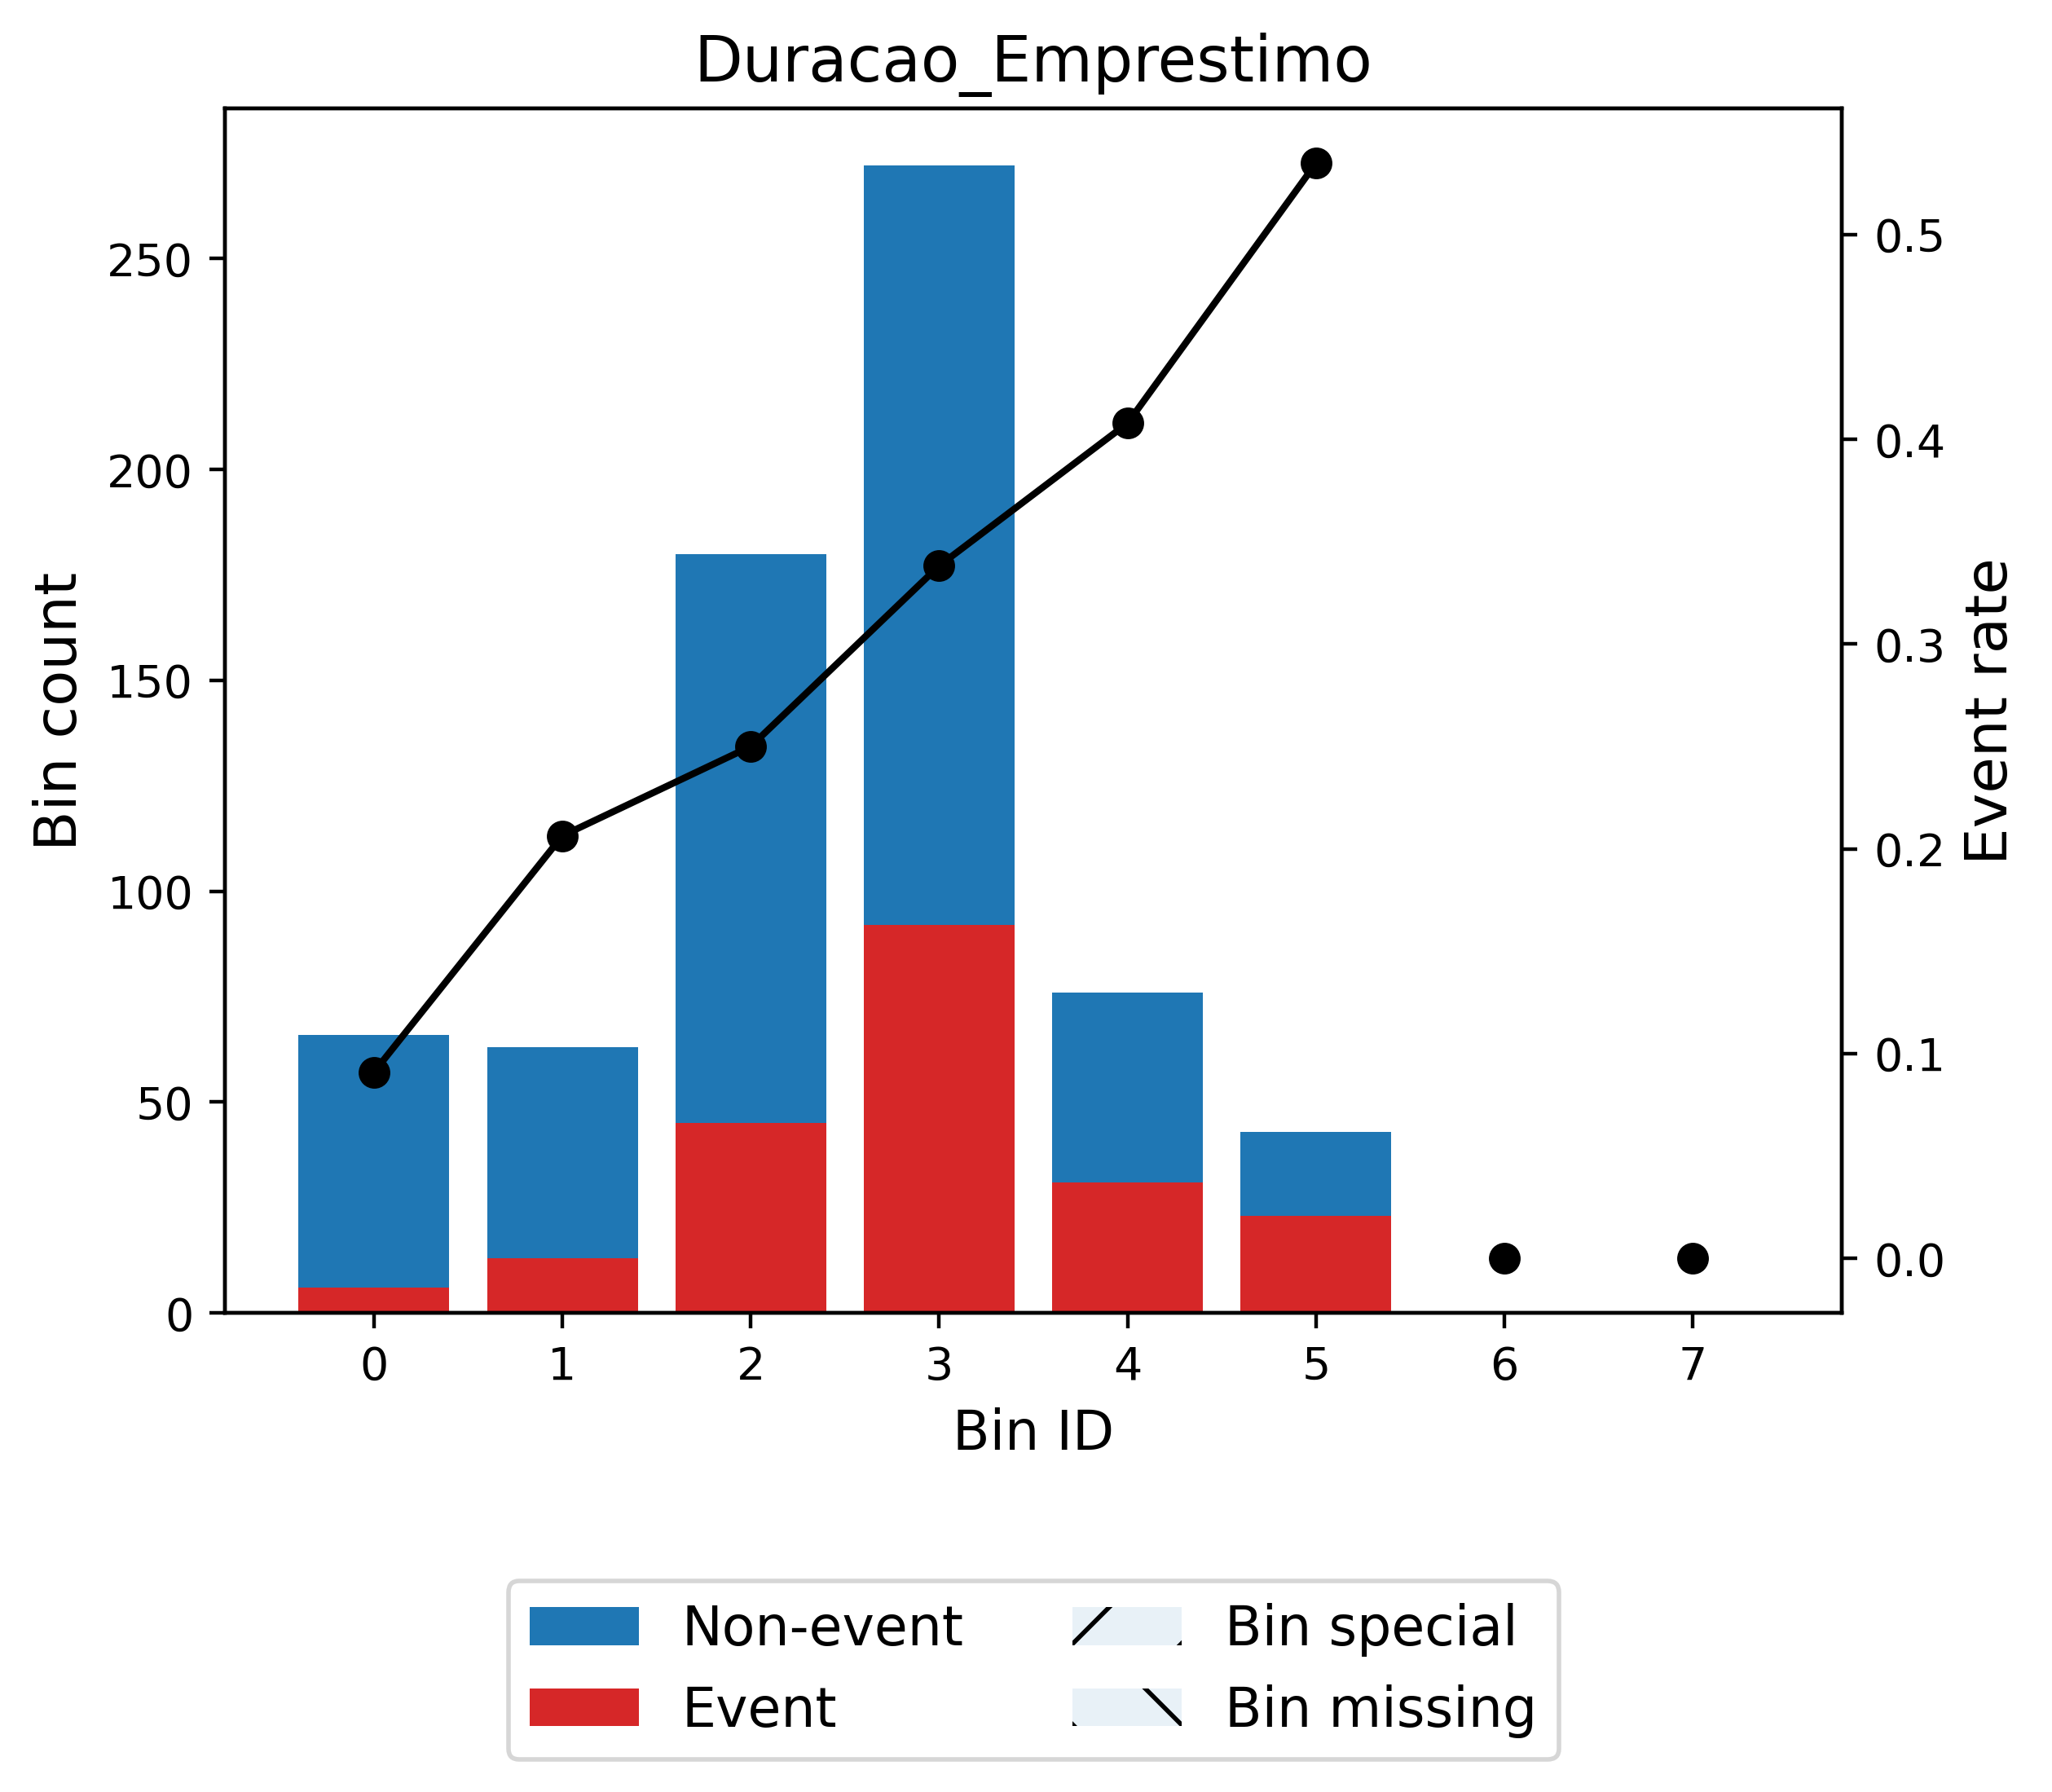

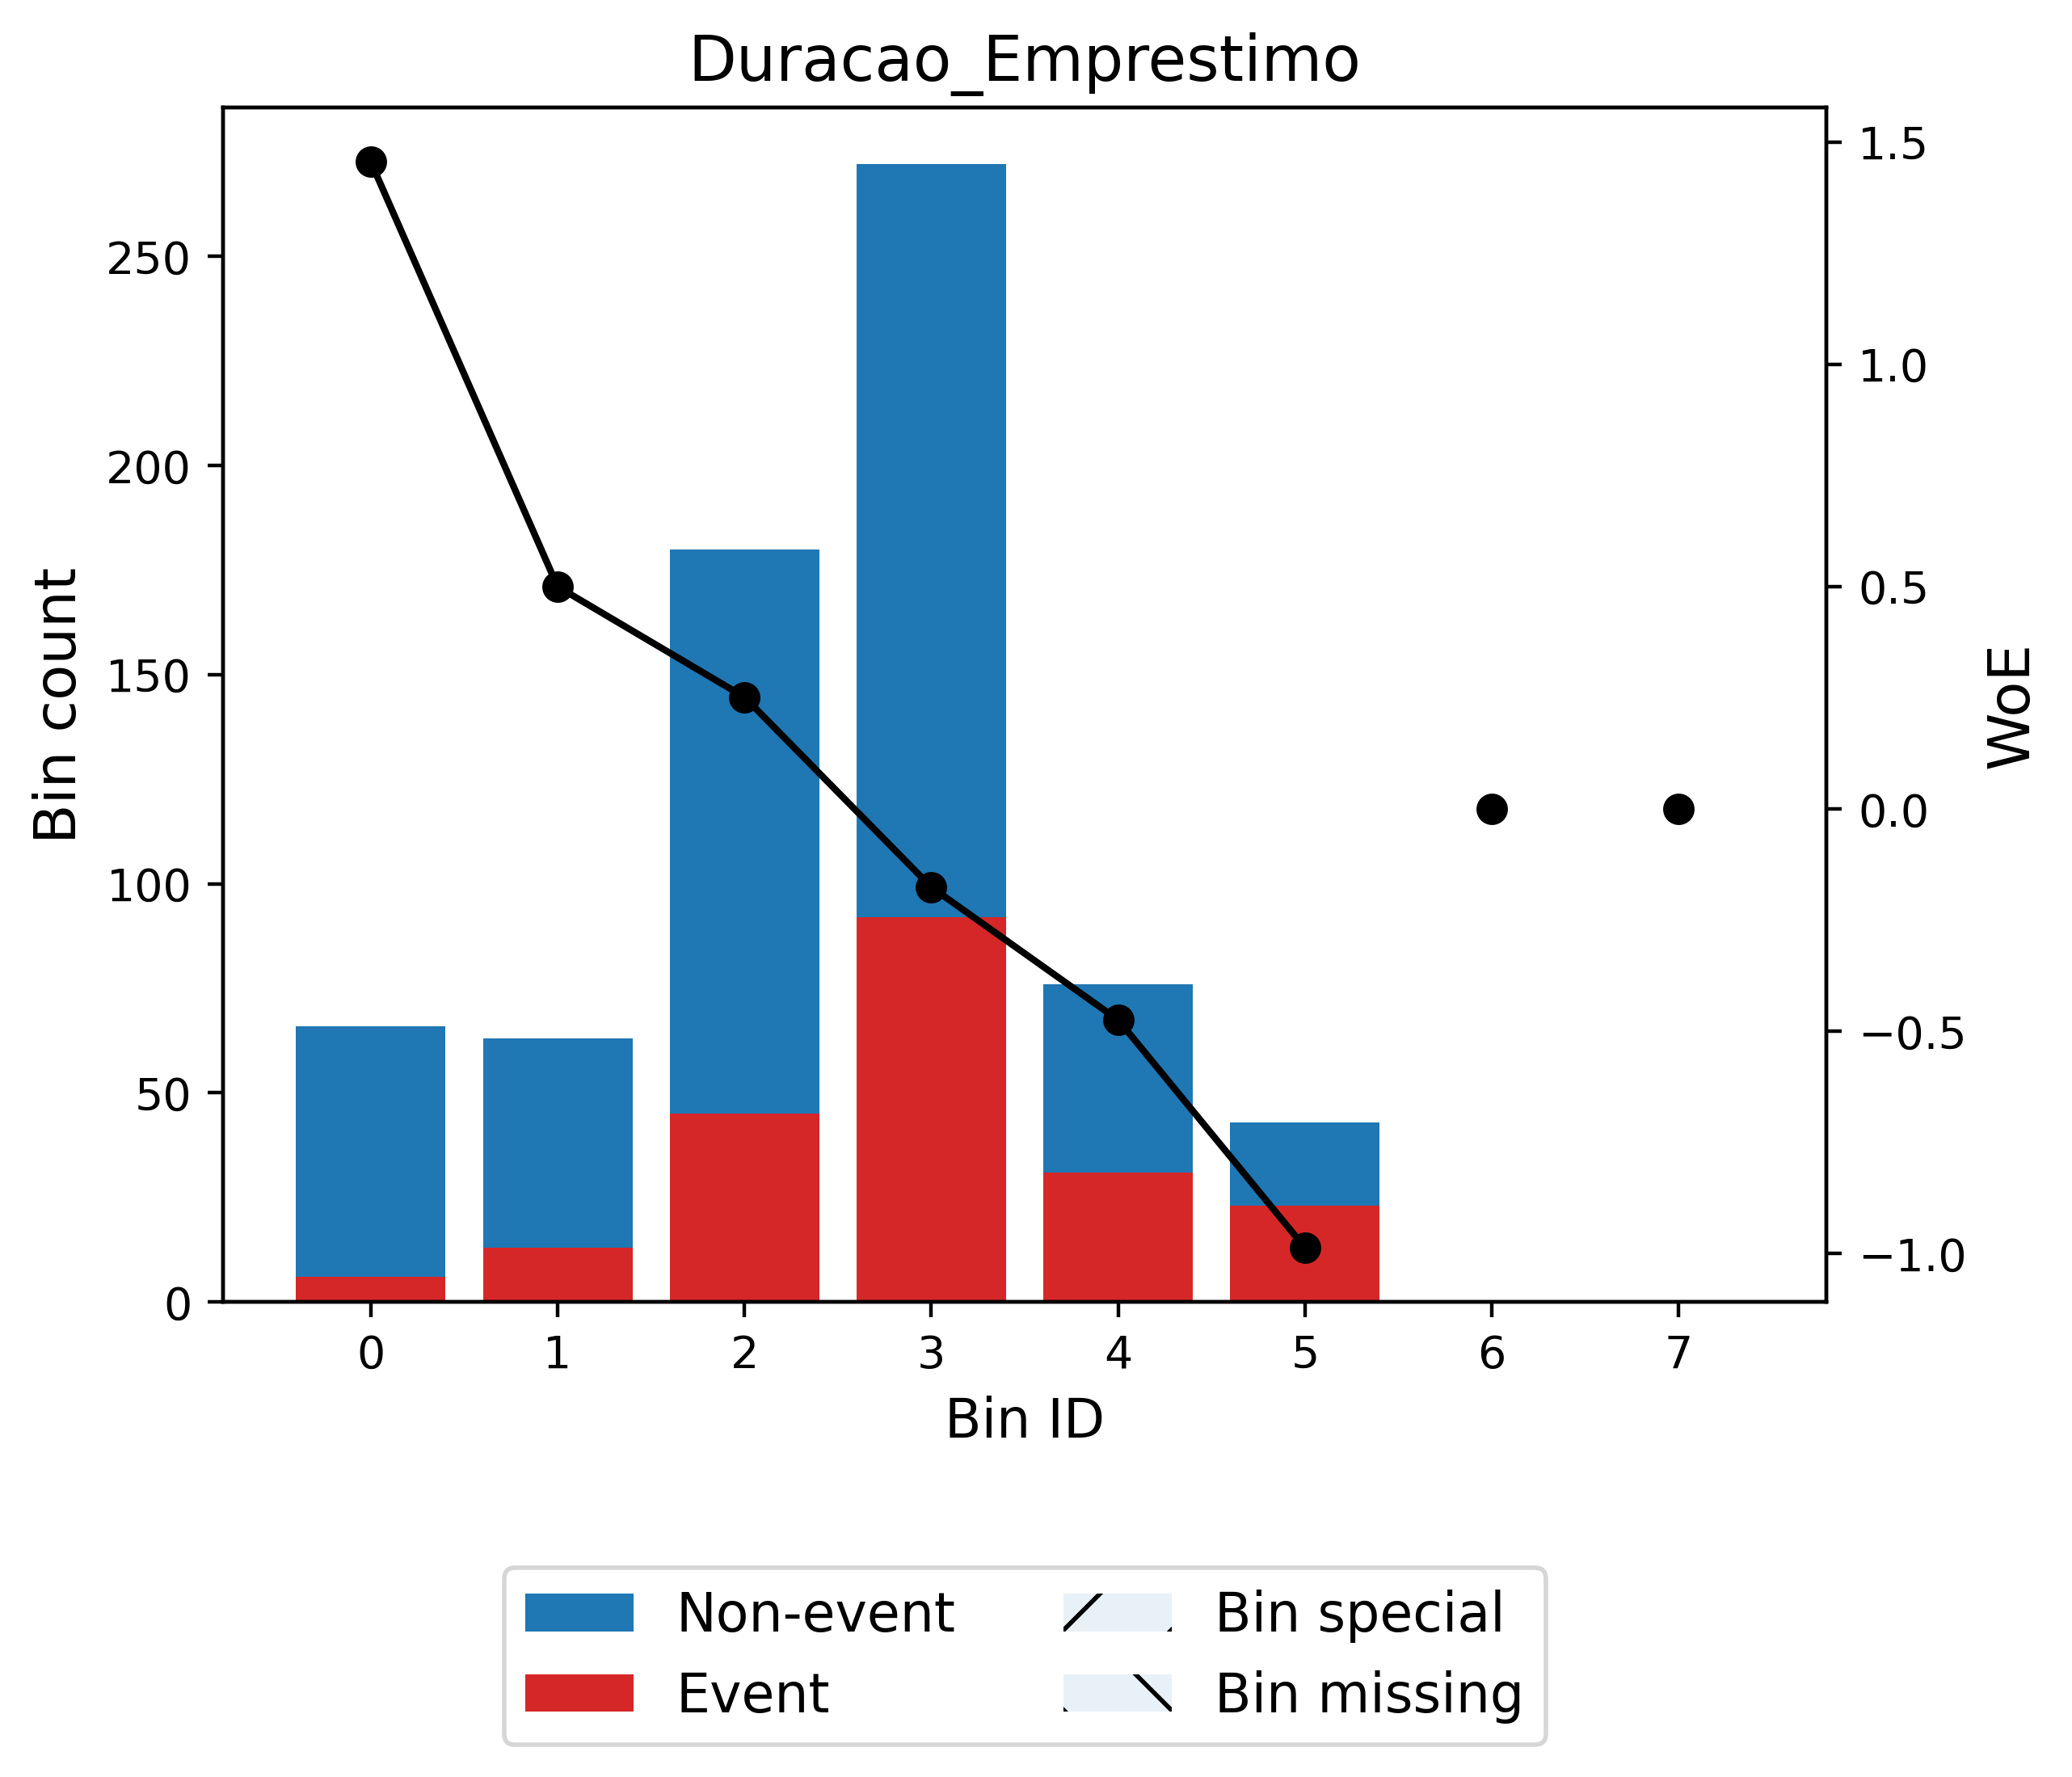

In [61]:
optb_dur.binning_table.plot(metric="event_rate")
optb_dur.binning_table.plot(metric="woe")

Conseguimos perceber a configuração monotônico que o modelo exige para essa variável. Conforme a variável aumenta, o WOE diminui e, isso é excelente, podemos manter essa váriavel no modelo.

Agora, por um caráter exploratório, vamos fazer para uma variável que sabemos que não responde a uma relação monotônica e que decidimos deixar no modelo para fins exploratórios como esse.

In [62]:
optb_inv = binning_models["Saldo_Investimento"]
inv_woe = optb_inv.binning_table.build()
inv_woe 

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Sem_Investimento],124,0.177,105,19,0.153,0.862,0.107,0.013
1,[Alto],78,0.111,66,12,0.154,0.857,0.066,0.008
2,[Pouco_Moderado],498,0.711,319,179,0.359,-0.269,0.054,0.007
3,Special,0,0.000,0,0,0.000,0.000,0.000,0.000
4,Missing,0,0.000,0,0,0.000,0.000,0.000,0.000
Totals,,700,1.000,490,210,0.300,,0.228,0.028


Aqui, a tabela por padrão não ordena por ordem dos bins mas, pelo valor de WOE. Portanto, não conseguimos ver o formato em U que representa a não montocidade desta variável. De qualquer forma, ao analisarmos atentamente a tabela acima, podemos chegar na conclusão de que o WOE apresenta oscilação não linear. O correto seria remover essa variável do modelo, mas decidimos manter apenas por caráter exploratório.

Vamos continuar nossa exploração gerando os scores e separando por faixas de risco.

In [43]:
contrib_df = X_train_woe.copy()

for col in contrib_df.columns:
    coef = coef_df.loc[coef_df["feature"] == col, "coef"].values[0]
    contrib_df[col] = contrib_df[col] * coef


In [44]:
import numpy as np

log_odds = contrib_df.sum(axis=1) + intercept

pd_score = 1 / (1 + np.exp(-log_odds))

# score "humano" (quanto maior, melhor)
score_norm = 1000 * (1 - pd_score)


In [45]:
df_score = pd.DataFrame({
    "score": score_norm,
    "pd": pd_score,
    "target": y_train
})

df_score

,score,pd,target
10,242.606,0.757,1
82,548.875,0.451,0
827,679.527,0.320,1
410,341.273,0.659,0
48,789.109,0.211,0
...,...,...,...
603,668.247,0.332,1
759,380.775,0.619,1
298,769.820,0.230,0
417,147.880,0.852,0


In [46]:
df_score["risk_band"] = pd.qcut(
    df_score["score"],
    q=5,
    labels=["E", "D", "C", "B", "A"]
)

df_score.groupby("risk_band")["target"].mean()


risk_band
E   0.636
D   0.436
C   0.236
B   0.143
A   0.050
Name: target, dtype: float64

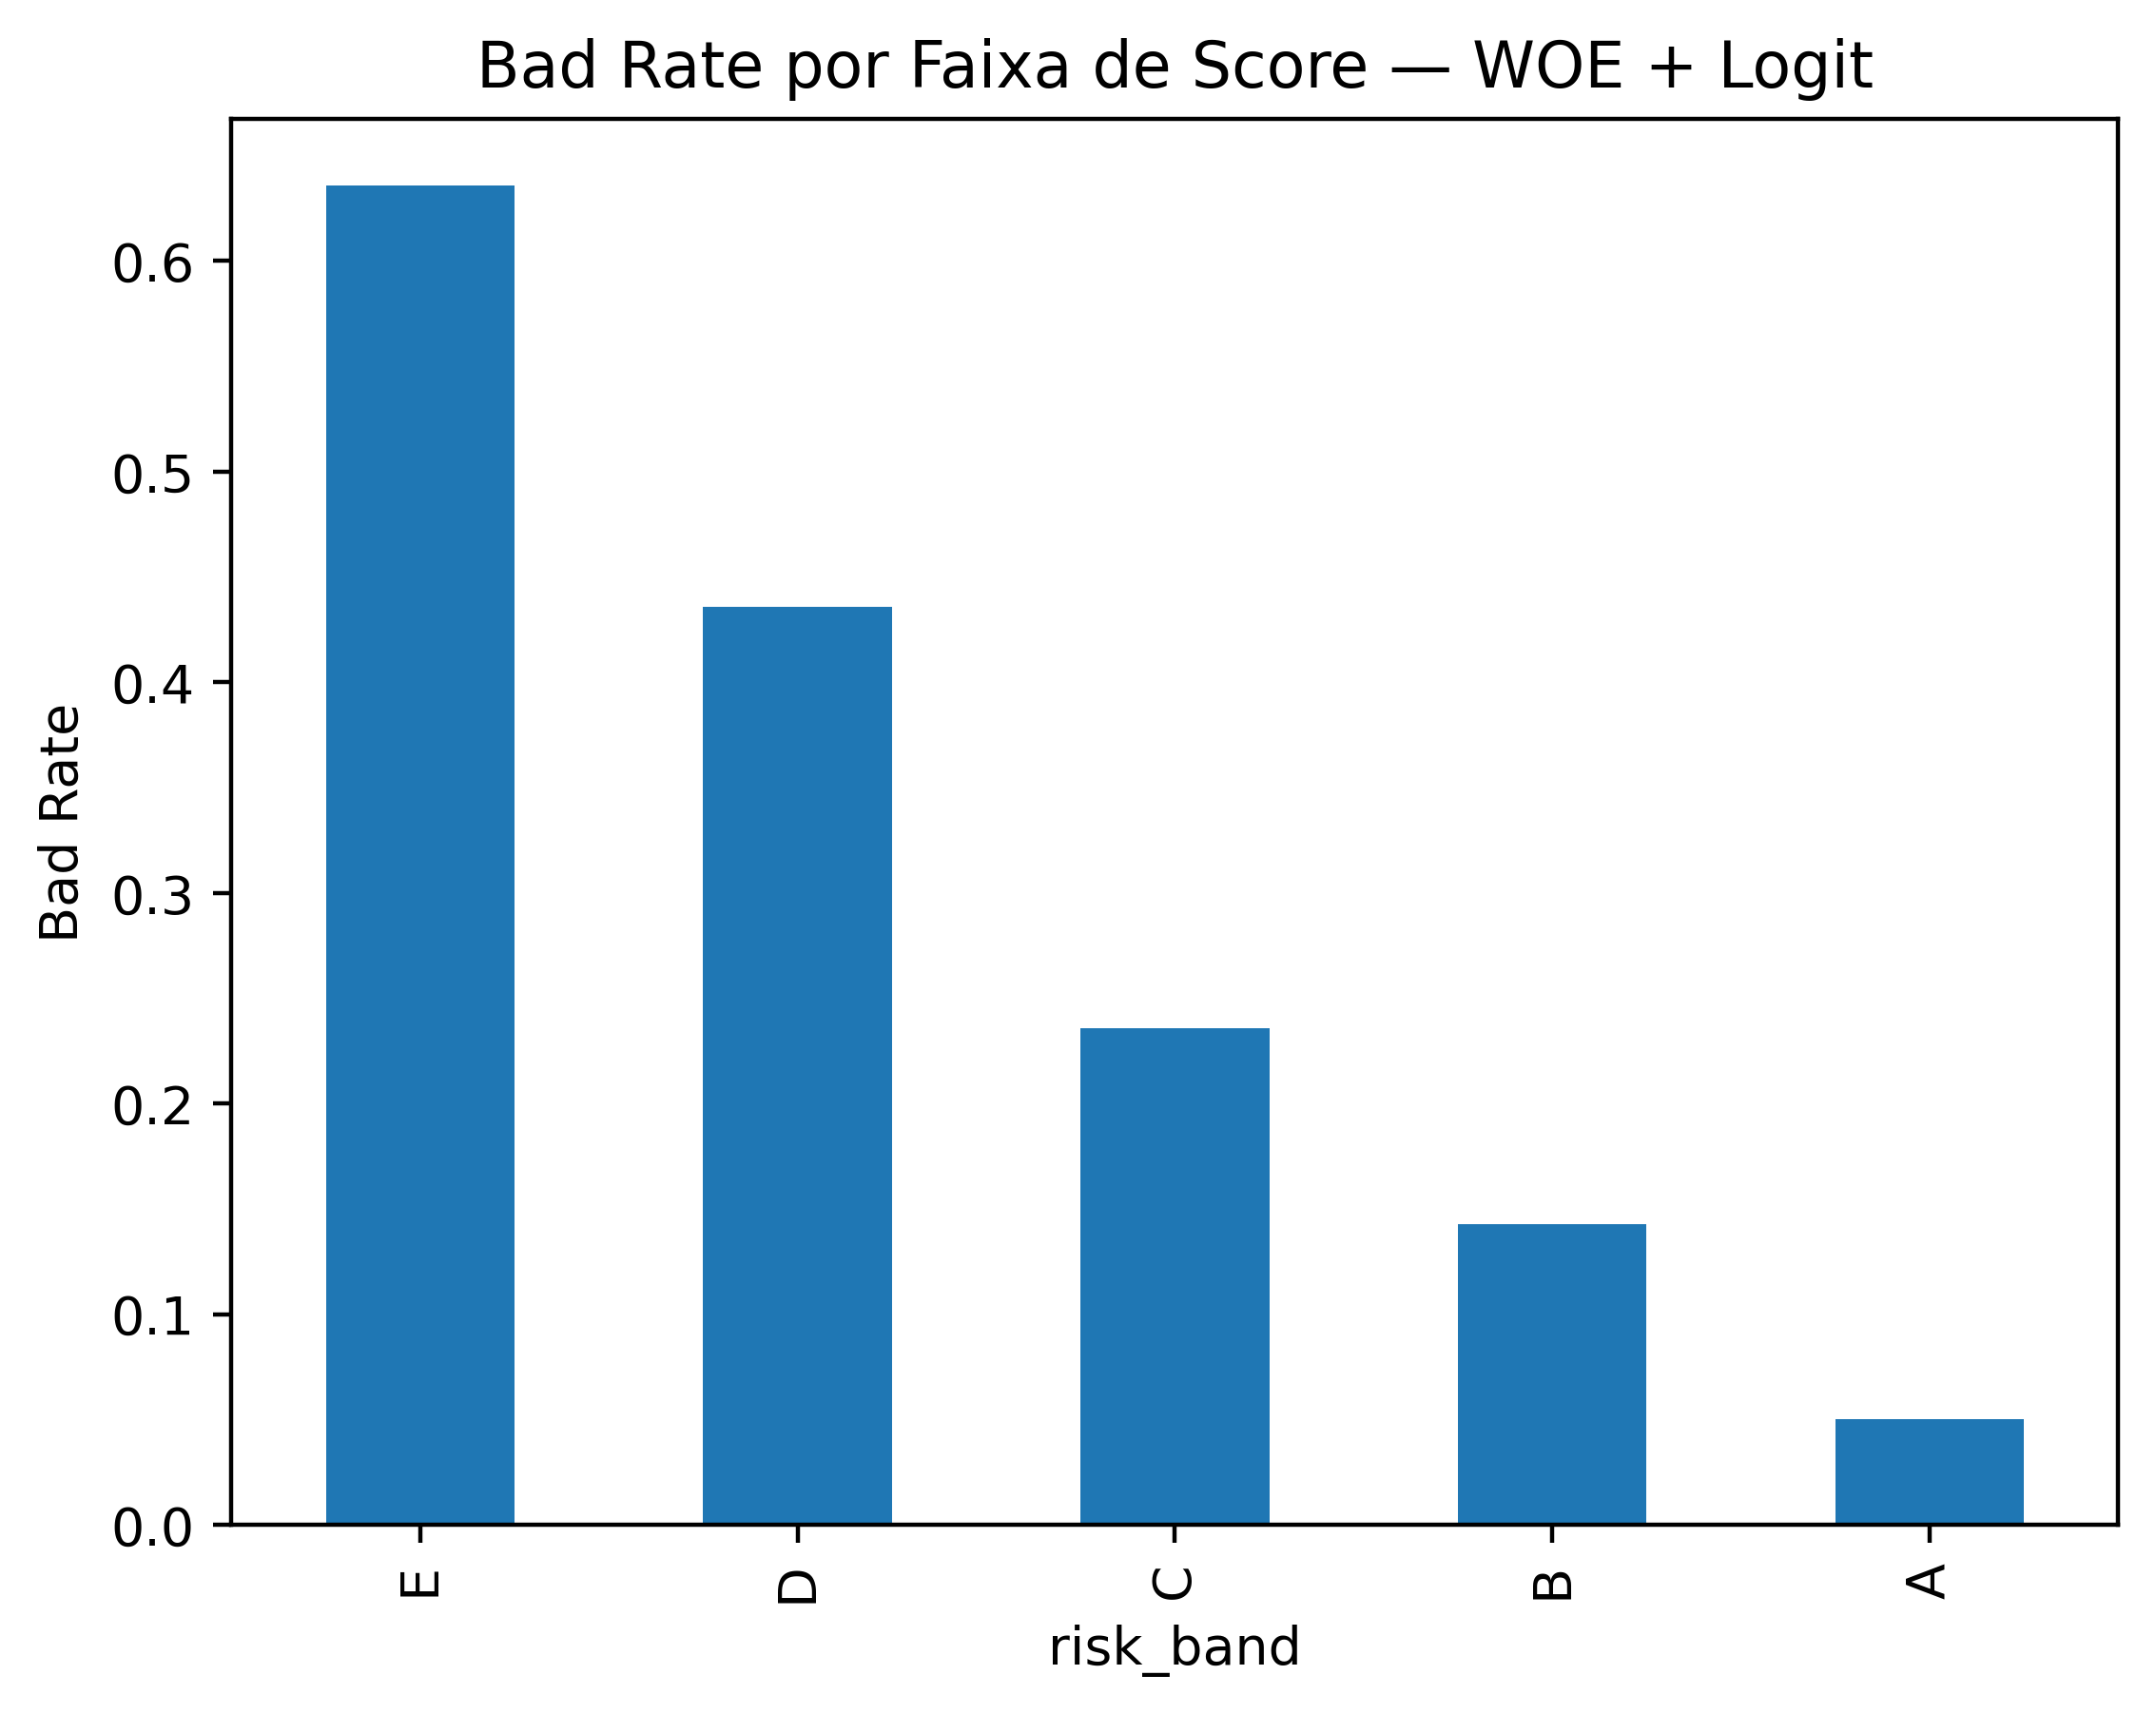

In [47]:
df_score.groupby("risk_band")["target"].mean().plot(
    kind="bar",
    title="Bad Rate por Faixa de Score — WOE + Logit"
)
plt.ylabel("Bad Rate")
plt.show()


# Considerações Finais

Com base nessas evidências, a regressão logística regularizada (Elastic Net) foi selecionada como modelo interpretável base, sendo encaminhada para a próxima etapa do projeto, na qual o foco deixa de ser a comparação de modelos e passa a ser a construção de políticas de decisão orientadas a retorno econômico (ROE). O ajuste de limiares de decisão e a definição de faixas de risco foram deliberadamente postergados para essa etapa, a fim de preservar a separação conceitual entre modelagem e decisão de crédito.

Em síntese, este notebook estabelece uma base sólida e tecnicamente defensável para a aplicação de modelos interpretáveis em crédito, priorizando generalização, estabilidade e valor econômico, e preparando o terreno para uma análise orientada à alocação eficiente de capital nos próximos estágios do projet

# Exportando

## Modelo Base

In [48]:
# criando o diretório de artefatos caso não exista
MODELS_ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# salvando o modelo âncora final
joblib.dump(
    logit_pipe,
    MODELS_ARTIFACTS_DIR / "logit_pipe.joblib"
)

['C:\\Users\\jooar\\ds\\portfolio\\credit-default-prediction\\artifacts\\models\\logit_pipe.joblib']

## Splits

In [49]:
# criando o diretório de splits caso não exista
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

train_idx = X_train.index.to_numpy()
test_idx = X_test.index.to_numpy()

np.save(SPLITS_DIR / "train_idx.npy", train_idx)
np.save(SPLITS_DIR / "test_idx.npy", test_idx)

In [50]:
# Exportando os folds da validação cruzada (OOF)
cv_folds = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    cv_folds.append({
        "fold": fold,
        "train_idx": train_idx.tolist(),
        "val_idx": val_idx.tolist()
    })

with open(SPLITS_DIR / "cv_folds.json", "w") as f:
    json.dump(cv_folds, f, indent=2)


## Métrica Econômica

In [51]:
# criando o diretório de artefatos caso não exista
METRIC_ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# json de configuração da métrica de payoff
payoff_config = {
  "scenario": "baseline_v1",

  "economic_assumptions": {
    "valor_medio_emprestimo": 3271.26,
    "margem_liquida": 0.10,
    "recovery_rate": 0.20,
    "custo_cobranca": 100.00
  },

  "derived_values": {
    "lucro_cliente_bom_formula": "margem_liquida * valor_medio_emprestimo",
    "prejuizo_cliente_mau_formula": "(1 - recovery_rate) * valor_medio_emprestimo + custo_cobranca"
  },

  "payoff_matrix_definition": {
    "matrix_order": {
      "y_true": ["bom_pagador (0)", "inadimplente (1)"],
      "y_pred": ["aprova (0)", "nega (1)"]
    },
    "payoff_matrix": [
      [ 327.13,  -327.13 ],
      [ -2717.01,  0.00 ]
    ]
  },

  "description": {
    "TP": "Aprovação correta de cliente bom (lucro líquido)",
    "FP": "Aprovação de cliente inadimplente (prejuízo)",
    "FN": "Negação de cliente bom (custo de oportunidade)",
    "TN": "Negação correta de cliente inadimplente"
  },

  "notes": "Classe positiva = inadimplência (1). y_pred=1 implica negação de crédito."
}


with open(METRIC_ARTIFACTS_DIR / "payoff_config.json", "w") as f:
    json.dump(payoff_config, f, indent=4)

# Próximos Passos

* Avaliação do ganho marginal de separação com GBM (LightGBM e XGB);
* Calibração das Propabilidades;
* Avaliação Econômica sob a matriz de custos fixo;
* Interpretabilidade e Governança;
* Definir Critério para a etapa de decisão de risco de crédito;